In [105]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Apple Mobility Data
***

#### Functions:

In [106]:
def save_AMD_Italy():
    '''
    Generates the reduced CSV to speed up the loading time
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends-2022-02-10.csv")
    df_out = applyfilter(df, {"country"  : ["Italy"], 
                              "geo_type" : ["sub-region"]})
    df_out.drop(["geo_type", "alternative_name", "sub-region", "country"], 1, inplace=True)
    #driving_norm, walking_norm = 0, 0
    # The following try except are implemented due to the fact that some regions lack the walking data
    #for region in region_name:
    #    
    #    try:
    #        walking_values += applyfilter(df_out, {"region" : [region], "transportation_type" : ["walking"]}).iloc[:,2:].values.flatten() * weight_dict[region]
    #    except Exception:
    #        pass
    #    else:
    #        walking_norm += weight_dict[region]
    #print(driving_norm,walking_norm)
    #df_tmp = pd.DataFrame([["Italy", "driving", *driving_values/driving_norm],
    #                       ["Italy", "walking", *walking_values/walking_norm]], columns=df_out.columns)
    #df_out = pd.concat([df_out, df_tmp], ignore_index=True)
    df_out.to_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv", index=False)

def load_AMD_Italy():
    '''
    Load the AMD referred to Italy and return the dataframe and the dates, 
    and eventually saves the list of all possible cities/regions
    '''
    df = pd.read_csv("DATA/AMD/applemobilitytrends_ITA-2022-02-10.csv")
    dates_str  = df.columns[2:] # list of sting
    return df, dates_str

def applyfilter(df, dictionary):
    '''
    Filter the dataframe according to the dictionary: the values needs to be a list
    The order matter
    '''
    df_out = df.copy()
    for key in dictionary.keys():
        sub_df = [df_out.loc[df_out[key] == val] for val in dictionary[key]]
        df_out = pd.concat(sub_df, ignore_index=True)

    return df_out

def fill_missing(df):
    '''
    AMD driving are missing for the 2020-05-11, 2020-05-12 
    AMD are missing for the 2021-03-12
    '''
    df_driv = df.loc[df["transportation_type"] == "driving", ["2020-05-10","2020-05-13"]]
    values = (df_driv["2020-05-10"].values + df_driv["2020-05-13"].values)/2
    df.loc[df["transportation_type"] == "driving", "2020-05-11"] = values
    df.loc[df["transportation_type"] == "driving", "2020-05-12"] = values
    df["2021-03-12"] = (df["2021-03-11"] + df["2021-03-13"])/2

def transform_week_RAVG(dataframe, cols, window=7):
    '''
    Substitute the mobility data with it's rolling average
    '''
    values = dataframe[cols].values
    RAVG = np.array([values[:,ii-window:ii].sum(axis=1)/window for ii in np.arange(window,len(cols)+1)]).T
    dataframe[cols[:window-1]] = np.NaN
    dataframe[cols[window-1:]] = RAVG
    
def from_to(date_list, start, end):
    '''
    Return the indexes of a date list corresponding to the period between 'start' and 'end'
    **
    If 'end' is an integer will be returned the time window of lenght 'end', starting from 'start'
    '''
    a = list(date_list).index(start)
    if (isinstance(end,int)):
        b = a+end
    else:
        b = list(date_list).index(end)
    return slice(a,b+1), np.arange(a,b+1)   # we need np because integer operation are not allowed on range object

#### Examples:

In [107]:
# Obviously needs to be run just the first time to generate the CVS
#save_AMD_Italy()
df_amd, dates_str_amd = load_AMD_Italy()
fill_missing(df_amd)
transform_week_RAVG(df_amd, dates_str_amd)
region_list_amd = np.unique(df_amd["region"].values)
dates_datetime_amd = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_amd]
df_amd.head()

region transportation_type  2020-01-13  2020-01-14  \
0                  Abruzzo Region             driving         NaN         NaN   
1                  Abruzzo Region             walking         NaN         NaN   
2                   Apulia Region             driving         NaN         NaN   
3                   Apulia Region             walking         NaN         NaN   
4  Autonomous Region Aosta Valley             driving         NaN         NaN   

   2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  2020-01-20  \
0         NaN         NaN         NaN         NaN  106.295714  106.267143   
1         NaN         NaN         NaN         NaN  111.790000  113.278571   
2         NaN         NaN         NaN         NaN  106.478571  106.725714   
3         NaN         NaN         NaN         NaN  110.544286  110.660000   
4         NaN         NaN         NaN         NaN  138.260000  138.518571   

   ...  2022-02-01  2022-02-02  2022-02-03  2022-02-04  2022-02-05  \
0  ...  138.440000  137.808571  137.991429  137.358571  136.084286   
1  ...  175.931429  176.121429  174.678571  172.627143  168.042857   
2  ...  129.600000  129.788571  130.055714  130.615714  131.090000   
3  ...  150.231429  151.904286  152.297143  152.602857  154.515714   
4  ...  184.881429  184.214286  185.864286  186.568571  183.064286   

   2022-02-06  2022-02-07  2022-02-08  2022-02-09  2022-02-10  
0  133.504286  134.070000  134.352857  135.762857  136.315714  
1  164.775714  163.804286  164.785714  165.158571  167.681429  
2  131.641429  132.187143  133.182857  134.434286  136.601429  
3  155.550000  155.257143  156.937143  158.192857  161.128571  
4  179.954286  180.338571  182.091429  183.322857  183.782857  

[5 rows x 762 columns]

In [108]:
print(region_list_amd)

['Abruzzo Region' 'Apulia Region' 'Autonomous Region Aosta Valley'
 'Autonomous Region Friuli-Venezia Giulia' 'Autonomous Region Sardinia'
 'Autonomous Region Trentino-Alto Adige/Südtirol' 'Basilicata Region'
 'Calabria Region' 'Campania Region' 'Emilia-Romagna Region'
 'Lazio Region' 'Liguria Region' 'Lombardy Region' 'Marche Region'
 'Molise Region' 'Piedmont Region' 'Sicily Region' 'Tuscany Region'
 'Umbria Region' 'Veneto Region']


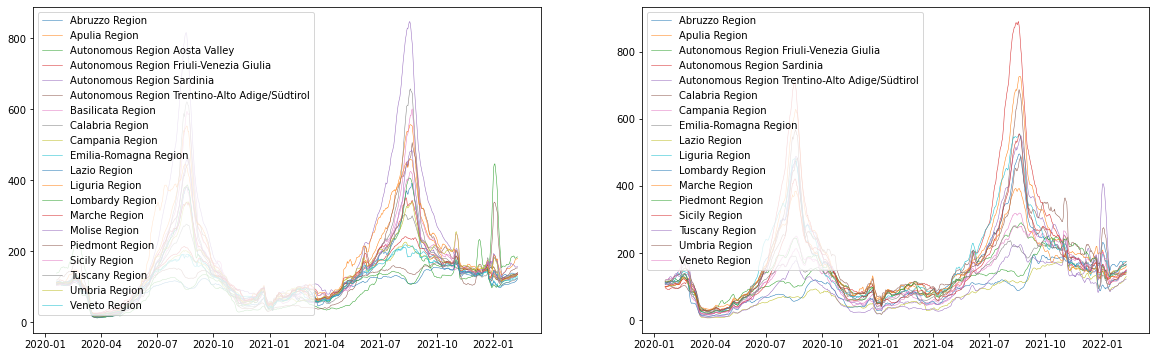

In [109]:
fig, ax = plt.subplots(1,2, figsize=[20,6])
for region in region_list_amd:
    try:
        ax[0].plot(dates_datetime_amd, applyfilter(df_amd, {"region" : [region]}).iloc[0,2:], label=region, linewidth=0.5)
    except Exception:
        pass
    
    try:
        ax[1].plot(dates_datetime_amd, applyfilter(df_amd, {"region" : [region]}).iloc[1,2:], label=region, linewidth=0.5)
    except Exception:
        pass
ax[0].legend()
ax[1].legend()
plt.show()

In [110]:
# To get the indexes of a given windows of time
#window_slice, window_mask = from_to(dates_list,"2020-03-21","2020-05-03")  # to a list we can just apply a slice

#fig, ax = plt.subplots(1,2, figsize=[20,6])

#ax[0].plot(dates_datetime[window_slice], applyfilter(df_ita, {"region" : ["Italy"]}).iloc[0,window_mask+2], linewidth=0.5)

#ax[1].plot(dates_datetime, applyfilter(df_ita, {"region" : ["Italy"]}).iloc[1,2:], linewidth=0.5)

#ax[0].legend()
#ax[1].legend()
#plt.show()

## Google Mobility Data
***

#### Functions:

In [111]:
def save_GMD():
    '''
    '''
    df_out = pd.DataFrame()
    for year in ['2020', '2021', '2022']:
        df = pd.read_csv("DATA/GMD/"+year+"_IT_Region_Mobility_Report.csv")
        mask_1 = np.logical_not(df['sub_region_1'].isnull())
        mask_2 = df['sub_region_2'].isnull()
        df.drop(labels = ["country_region_code", "country_region", "sub_region_2", 'metro_area','iso_3166_2_code',
                 'census_fips_code', 'place_id'], axis=1, inplace=True)
        df_out = pd.concat([df_out, df[mask_1 & mask_2]], ignore_index=True)
    df_out.to_csv('DATA/GMD/GMD_final.csv', index=False)

def load_GMD():
    '''
    '''
    df = pd.read_csv("DATA/GMD/GMD_final.csv")
    df['residential_percent_change_from_baseline'] = 100-df['residential_percent_change_from_baseline']
    dates_str = np.unique(df["date"])
    return df, dates_str

#### Examples:

In [112]:
#save_GMD()
df_gmd, dates_str_gmd = load_GMD()
region_list_gmd = np.unique(df_gmd["sub_region_1"].values)
dates_datetime_gmd = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_gmd]
df_gmd.head()

sub_region_1        date  \
0      Abruzzo  2020-02-15   
1      Abruzzo  2020-02-16   
2      Abruzzo  2020-02-17   
3      Abruzzo  2020-02-18   
4      Abruzzo  2020-02-19   

   retail_and_recreation_percent_change_from_baseline  \
0                                                2.0    
1                                                2.0    
2                                               -1.0    
3                                                1.0    
4                                               -4.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                2.0   
1                                                8.0   
2                                                2.0   
3                                                2.0   
4                                               -1.0   

   parks_percent_change_from_baseline  \
0                                36.0   
1                                47.0   
2                                11.0   
3                                22.0   
4                               -12.0   

   transit_stations_percent_change_from_baseline  \
0                                            9.0   
1                                           26.0   
2                                            7.0   
3                                            5.0   
4                                            1.0   

   workplaces_percent_change_from_baseline  \
0                                      0.0   
1                                     -1.0   
2                                      1.0   
3                                      2.0   
4                                      1.0   

   residential_percent_change_from_baseline  
0                                     101.0  
1                                     102.0  
2                                     101.0  
3                                     101.0  
4                                     100.0

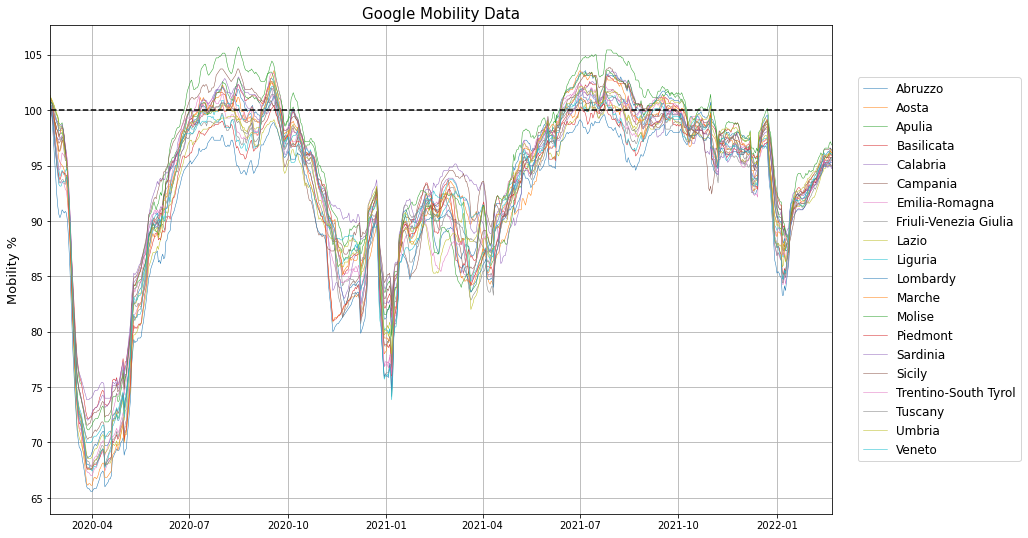

In [113]:
plt.figure(figsize=[14,9])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors_cycle = prop_cycle.by_key()['color']

for color,region in zip([*colors_cycle,*colors_cycle,*colors_cycle], region_list_gmd):
    plt.plot(dates_datetime_gmd, applyfilter(df_gmd, {"sub_region_1" : [region]}).iloc[:,7].rolling(7).mean(), label=region, linewidth=0.5, color=color)
    
plt.xlim(dates_datetime_gmd[7], dates_datetime_gmd[-1])
plt.hlines([100], dates_datetime_gmd[0], dates_datetime_gmd[-1], 'black', '--' )
#handles, labels = ax[0].get_legend_handles_labels()
plt.legend(loc='center right', bbox_to_anchor=(1.25,0.5), fontsize=12)
plt.title('Google Mobility Data', fontsize = 15)
plt.ylabel('Mobility %', fontsize = 13)
plt.grid()
#ax[0].legend()
#plt.save('images/AMD_plot.jpeg')
plt.show()

## Protezione civile
***

#### Functions:

In [114]:
def save_prot_civ():
    df = pd.read_csv("DATA/prot_civ/itaregioni.csv")
    #df = df[['data', 'denominazione_regione', 'nuovi_positivi', 'totale_casi']]
    df = df[['data', 'denominazione_regione', 'nuovi_positivi', 'totale_casi', 'ricoverati_con_sintomi', 'ingressi_terapia_intensiva', 'tamponi']]
    df_trentino = df[(df['denominazione_regione'] == 'P.A. Bolzano') | (df['denominazione_regione'] == 'P.A. Trento')].groupby('data', as_index = False).sum()
    df_trentino['denominazione_regione'] = 'Trentino alto adige' 
    df_prot_civ = pd.concat([df, df_trentino], ignore_index=True)
    df_prot_civ = df_prot_civ[(df_prot_civ['denominazione_regione'] != 'P.A. Bolzano') & (df_prot_civ['denominazione_regione'] != 'P.A. Trento')]
    #df_prot_civ = df ## remove to backup
    df_prot_civ['data'] = [date.split('T')[0] for date in df_prot_civ['data']]
    df_prot_civ.to_csv("DATA/prot_civ/itaregioni_final.csv", index=False)

def load_prot_civ():
    '''
    '''
    df = pd.read_csv("DATA/prot_civ/itaregioni_final.csv")
    dates_str = np.unique(df["data"])
    return df, dates_str

(0.0, 10.0)

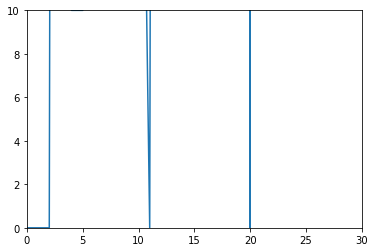

In [115]:
prova = pd.read_csv("DATA/prot_civ/itaregioni.csv")
#plt.plot(prova[prova['denominazione_regione'] == 'Abruzzo'].tamponi)
plt.plot(prova[prova['denominazione_regione']=='Puglia'].tamponi.values[1:] - prova[prova['denominazione_regione']=='Puglia'].tamponi.values[:-1])
plt.xlim(0,30)
plt.ylim(0,10)
#prova_m = df_norm.loc[df_norm['denominazione_regione'] == "Valle d'Aosta" ,'nuovi_tamponi'].values <= 0
#[*prova_m[1:],prova_m[1:]]
#df_norm.loc[df_norm['denominazione_regione'] == 'Abruzzo', 'nuovi_tamponi'] == 0
#df_norm.loc[mask&(df_norm['data']=='2020-02-25T18:00:00'), 'nuovi_tamponi']
#np.unique(df_norm['nuovi_tamponi'] == 0)
#prova[prova['denominazione_regione'] == 'Emilia-Romagna'].tamponi
#prova[prova['denominazione_regione']=='Emilia-Romagna'].tamponi.values[1:] - prova[prova['denominazione_regione']=='Emilia-Romagna'].tamponi.values[:-1]
#np.unique(df_norm.loc[df_norm['denominazione_regione'] == 'Emilia-Romagna', 'nuovi_tamponi'])

In [116]:
_, dates_datetime_norm = load_prot_civ()
df_norm = pd.read_csv("DATA/prot_civ/itaregioni.csv")
df_norm['nuovi_tamponi']    = np.NaN
#df['nuovi_ricoverati'] = np.NaN
df_norm['incidence_norm']   = np.NaN
#df['ricoverati_norm']  = np.NaN
for regione in np.unique(df_norm.denominazione_regione):
    mask = df_norm['denominazione_regione'] == regione
    df_norm.loc[mask, 'nuovi_tamponi']    = [np.NaN,*(df_norm.loc[mask, 'tamponi'][1:].values - df_norm.loc[mask, 'tamponi'][:-1].values)]
    if (df_norm.loc[mask&(df_norm['data']=='2020-02-25T18:00:00'), 'nuovi_tamponi'].values == 0) :
        df_norm.loc[mask&(df_norm['data']=='2020-02-25T18:00:00'), 'nuovi_tamponi'] = 1
    #df_norm['nuovi_tamponi'].values < 0
    for i in range(26):
        mask_err_big = df_norm['nuovi_tamponi'].values <= 0
        #mask_err_sma = df_norm[mask]['nuovi_tamponi'].values <= 0
        mask_shi = [*mask_err_big[21:],*[False]*21]
        df_norm.loc[mask&mask_err_big]    = df_norm.loc[mask&mask_shi].values
    #df.loc[mask, 'nuovi_ricoverati'] = [np.NaN,*(df.loc[mask, 'ricoverati_con_sintomi'][1:].values - df.loc[mask, 'ricoverati_con_sintomi'][:-1].values)] 
    df_norm.loc[mask, 'incidence_norm']   = (df_norm.loc[mask, 'nuovi_positivi'].values / df_norm.loc[mask, 'nuovi_tamponi'].values) 
    #df.loc[mask, 'ricoverati_norm']  = (df.loc[mask, 'nuovi_ricoverati'].values - df.loc[mask, 'nuovi_tamponi'].values) 
df_norm

data stato  codice_regione denominazione_regione  \
0      2020-02-24T18:00:00   ITA            13.0               Abruzzo   
1      2020-02-24T18:00:00   ITA            17.0            Basilicata   
2      2020-02-24T18:00:00   ITA            18.0              Calabria   
3      2020-02-24T18:00:00   ITA            15.0              Campania   
4      2020-02-24T18:00:00   ITA             8.0        Emilia-Romagna   
...                    ...   ...             ...                   ...   
15136  2022-02-13T17:00:00   ITA            19.0               Sicilia   
15137  2022-02-13T17:00:00   ITA             9.0               Toscana   
15138  2022-02-13T17:00:00   ITA            10.0                Umbria   
15139  2022-02-13T17:00:00   ITA             2.0         Valle d'Aosta   
15140  2022-02-13T17:00:00   ITA             5.0                Veneto   

             lat       long  ricoverati_con_sintomi  terapia_intensiva  \
0      42.351222  13.398438                     0.0                0.0   
1      40.639471  15.805148                     0.0                0.0   
2      38.905976  16.594402                     0.0                0.0   
3      40.839566  14.250850                     0.0                0.0   
4      44.494367  11.341721                    10.0                2.0   
...          ...        ...                     ...                ...   
15136  38.115697  13.362357                  1294.0              115.0   
15137  43.769231  11.255889                  1109.0               81.0   
15138  43.106758  12.388247                   197.0                6.0   
15139  45.737503   7.320149                    40.0                4.0   
15140  45.434905  12.338452                   992.0               76.0   

       totale_ospedalizzati  isolamento_domiciliare  ...  note_test  \
0                       0.0                     0.0  ...        NaN   
1                       0.0                     0.0  ...        NaN   
2                       0.0                     0.0  ...        NaN   
3                       0.0                     0.0  ...        NaN   
4                      12.0                     6.0  ...        NaN   
...                     ...                     ...  ...        ...   
15136                1409.0                258597.0  ...        NaN   
15137                1190.0                 72693.0  ...        NaN   
15138                 203.0                 14464.0  ...        NaN   
15139                  44.0                  2075.0  ...        NaN   
15140                1068.0                107098.0  ...        NaN   

                                               note_casi  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
15136  Sul numero complessivo dei casi confermati com...   
15137                                                NaN   
15138                                                NaN   
15139                                                NaN   
15140                                                NaN   

       totale_positivi_test_molecolare  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   
...                                ...   
15136                         472469.0   
15137                         538175.0   
15138                         114317.0   
15139                          13937.0   
15140                         733688.0   

       totale_positivi_test_antigenico_rapido  tamponi_test_molecolare  \
0                                         NaN                      NaN   
1                

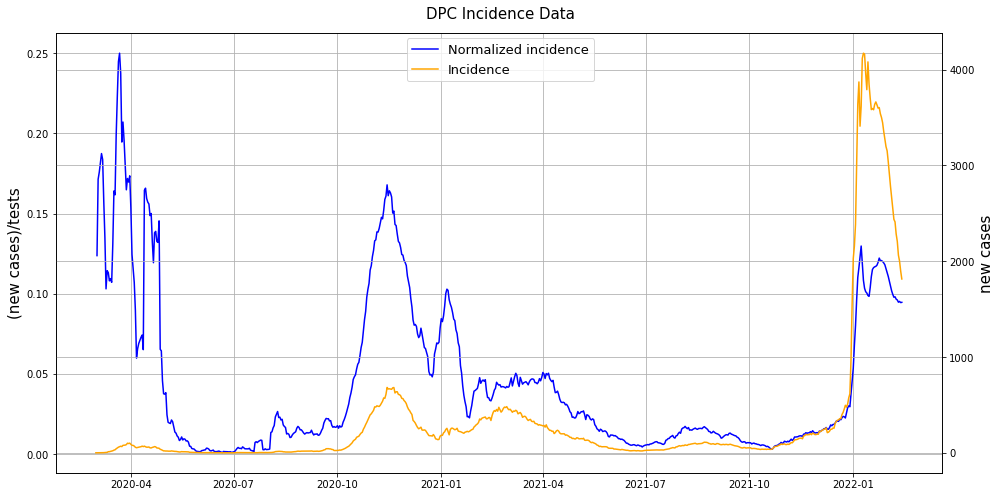

In [117]:
fig, ax1 = plt.subplots(figsize=(14,7))
ax2 = ax1.twinx()
ax1.plot(dates_datetime_pc, df_norm[df_norm['denominazione_regione'] == 'Abruzzo'].incidence_norm.rolling(7).mean(), 
         label='Normalized incidence', color='blue')
ax2.plot(dates_datetime_pc, df_norm[df_norm['denominazione_regione'] == 'Abruzzo'].nuovi_positivi.rolling(7).mean(),
         label='Incidence', color='orange')
ax1.set_ylabel('(new cases)/tests', fontsize=15)
ax2.set_ylabel('new cases', fontsize=15)
ax1.grid()
ax2.grid()
fig.legend(loc = 'upper center', fontsize=13, bbox_to_anchor=(0.5,0.93))
fig.suptitle('DPC Incidence Data', fontsize=15)
fig.tight_layout()
plt.show()

In [118]:
df_norm.shape

(15141, 32)

#### Examples:

In [119]:
# To run just the first time
save_prot_civ()
df_pc, dates_str_pc = load_prot_civ()
region_list_pc = np.unique(df_pc["denominazione_regione"].values)
dates_datetime_pc = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates_str_pc]
df_pc.head()
#dates_datetime_pc

data denominazione_regione  nuovi_positivi  totale_casi  \
0  2020-02-24               Abruzzo               0            0   
1  2020-02-24            Basilicata               0            0   
2  2020-02-24              Calabria               0            0   
3  2020-02-24              Campania               0            0   
4  2020-02-24        Emilia-Romagna              18           18   

   ricoverati_con_sintomi  ingressi_terapia_intensiva  tamponi  
0                       0                         NaN        5  
1                       0                         NaN        0  
2                       0                         NaN        1  
3                       0                         NaN       10  
4                      10                         NaN      148

In [120]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "Veneto"]

region_dict = dict(sorted({key : value for key,value in zip(region_sorted_pc, region_list_amd)}.items()))  #just for AMD!!
actual_regions = list(region_dict.keys())
acrual_regions = actual_regions.remove('Trentino alto adige')

In [121]:
region_dict_GMD = {'Abruzzo': 'Abruzzo',
                   'Basilicata': 'Basilicata',
                   'Calabria': 'Calabria',
                   'Campania': 'Campania',
                   'Emilia-Romagna': 'Emilia-Romagna',
                   'Friuli Venezia Giulia': 'Friuli-Venezia Giulia',
                   'Lazio': 'Lazio',
                   'Liguria': 'Liguria',
                   'Lombardia': 'Lombardy',
                   'Marche': 'Marche',
                   'Molise': 'Molise',
                   'Piemonte': 'Piedmont',
                   'Puglia': 'Apulia',
                   'Sardegna': 'Sardinia',
                   'Sicilia': 'Sicily',
                   'Toscana': 'Tuscany',
                   #'Trentino alto adige': 'Autonomous Region Trentino-Alto Adige/Südtirol',
                   'Umbria': 'Umbria',
                   "Valle d'Aosta": 'Aosta',
                   'Veneto': 'Veneto'}

## Rt ISS
***

#### Functions:

In [122]:
def save_rt():
    '''
    '''
    df_rt = pd.DataFrame()
    for region in actual_regions:
        if (region=="Valle d'Aosta"):
            region_tmp = "valle_daosta"
        elif (region=="Friuli Venezia Giulia"):
            region_tmp = "friuli_venezia_giulia"
        elif (region=="Emilia-Romagna"):
            region_tmp = "emilia_romagna"
        else:
            region_tmp = region.lower()
        df_tmp = pd.read_csv('rt/iss_rt_'+region_tmp+'.csv')
        df_tmp['denominazione_regione'] = region
        df_rt = pd.concat([df_rt, df_tmp], ignore_index=True)
        df_rt.to_csv("DATA/dataset_rt_iss.csv", index=False)
    
def load_rt():
    '''
    '''
    df = pd.read_csv("DATA/dataset_rt_iss.csv")
    dates_str = np.unique(df["data"])
    return df, dates_str

In [123]:
#save_rt()
df_rt, dates_str_rt = load_rt() 
df_rt

data  rt_positivi  rt_positivi_err68perc  rt_sintomatici  \
0      2020-02-12          NaN                    NaN             NaN   
1      2020-02-13          NaN                    NaN             NaN   
2      2020-02-14          NaN                    NaN             NaN   
3      2020-02-15          NaN                    NaN             NaN   
4      2020-02-16          NaN                    NaN             NaN   
...           ...          ...                    ...             ...   
14189  2022-02-16     0.693648               0.065066        0.696026   
14190  2022-02-17     0.683205               0.066464        0.685451   
14191  2022-02-18     0.672440               0.067883        0.674492   
14192  2022-02-19     0.660524               0.069474        0.662358   
14193  2022-02-20     0.647702               0.071185        0.649274   

       rt_sintomatici_err68perc denominazione_regione  
0                           NaN               Abruzzo  
1                           NaN               Abruzzo  
2                           NaN               Abruzzo  
3                           NaN               Abruzzo  
4                           NaN               Abruzzo  
...                         ...                   ...  
14189                  0.064740                Veneto  
14190                  0.066171                Veneto  
14191                  0.067630                Veneto  
14192                  0.069264                Veneto  
14193                  0.071021                Veneto  

[14194 rows x 6 columns]

## Colors
***

In [124]:
def generate_tseries(df):
    
    start_date = df.iloc[0,0]
    out = {'bianco'    : [],
           'giallo'    : [],
           'arancione' : [],
           'rosso'     : []}
    
    for row in range(1,len(df)-1):
        curr_date  = df.iloc[row,0]
        curr_color = df.iloc[row,2]
        # if new color
        if (curr_color != df.iloc[row-1,2]):
            start_date = curr_date
        # if last color
        if (curr_color != df.iloc[row+1,2]):
            out[curr_color].append((start_date, curr_date))
    out[df.iloc[row,2]].append((start_date, df.iloc[row,0]))
    return out

In [125]:
colors = pd.read_csv('DATA/dataset_colori.csv')
prova = generate_tseries(applyfilter(colors, {'denominazione_regione' : ['Provincia autonoma Bolzano']}))
colors

data denominazione_regione     colore
0     2020-11-06               Abruzzo     giallo
1     2020-11-07               Abruzzo     giallo
2     2020-11-08               Abruzzo     giallo
3     2020-11-09               Abruzzo     giallo
4     2020-11-10               Abruzzo  arancione
...          ...                   ...        ...
9823  2022-02-12                Veneto     giallo
9824  2022-02-13                Veneto     giallo
9825  2022-02-14                Veneto     giallo
9826  2022-02-15                Veneto     giallo
9827  2022-02-16                Veneto     giallo

[9828 rows x 3 columns]

In [126]:
waves_dict = {'wave_twindow': [('2020-10-01', '2021-01-31'),
                             ('2021-02-01', '2021-05-31'),
                             ('2021-06-01', '2021-10-31'),
                             ('2021-11-01', '2022-02-13')]}

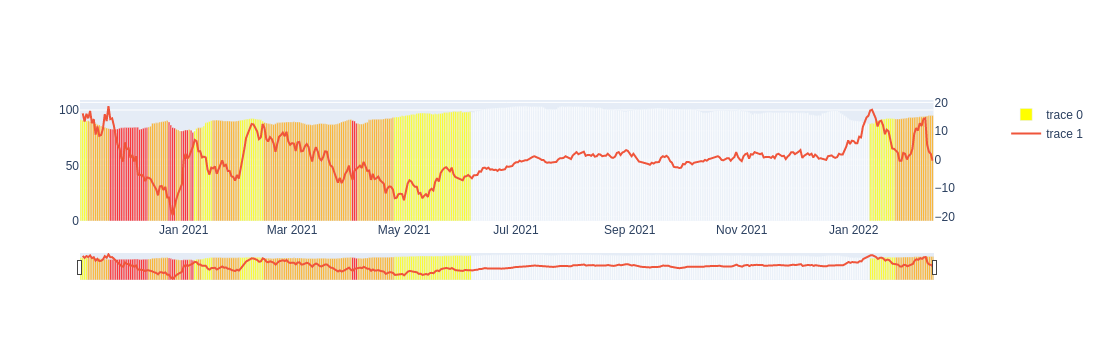

In [127]:
#df_mob = applyfilter(df_amd, {"region" : [region_dict['Lazio']]}).iloc[:, 2:]
df_mob = applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD['Abruzzo']]}).iloc[:, 7].rolling(window=7).mean()
df_col = applyfilter(colors, {'denominazione_regione' : ['Abruzzo']})
df_inc = applyfilter(df_pc, {"denominazione_regione" : ['Abruzzo']}).iloc[:,2:].rolling(window=7).mean()
translate = {'bianco'    : 'white',
             'giallo'    : 'yellow',
             'arancione' : 'orange',
             'rosso'     : 'red'}
color_list = [translate[col] for col in df_col.colore.values]
start_date = df_col.iloc[0,0]
#end_date   = dates_str_amd[-1]
#slice_mob, mask_mob = from_to(dates_str_amd, start_date, end_date)
end_date   = dates_str_pc[-1]
slice_mob, mask_mob = from_to(dates_str_gmd, start_date, end_date)

_, mask_col = from_to(df_col.data.values, start_date, end_date)
_, mask_inc = from_to(dates_str_pc, start_date, end_date)

fig = make_subplots(specs=[[{"secondary_y": True}]])
#fig.add_trace(go.Bar(x=dates_datetime_amd[slice_mob], y=df_mob.iloc[0,mask_mob], marker_color=color_list), secondary_y=False)
#fig.add_trace(go.Scatter(x=dates_datetime_amd[slice_mob], y=df_inc.iloc[mask_inc, 0]), secondary_y=True)

fig.add_trace(go.Bar(x=dates_datetime_gmd[slice_mob], y=df_mob[mask_mob], marker_color=color_list), secondary_y=False)
#fig.add_trace(go.Scatter(x=dates_datetime_gmd[slice_mob], y=df_inc.iloc[mask_inc, 0]), secondary_y=True)
fig.add_trace(go.Scatter(x=dates_datetime_gmd[slice_mob][1:], y=df_inc.iloc[mask_inc, 2][1:].values - df_inc.iloc[mask_inc, 2][:-1].values), secondary_y=True)


fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(fixedrange=False)
fig.show()#render='jupyterlab')

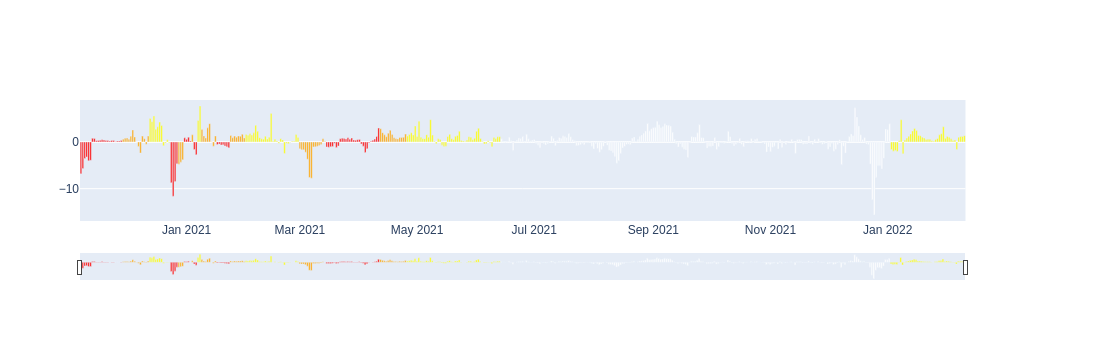

In [128]:
df_mob = applyfilter(df_amd, {"region" : [region_dict['Lombardia']]}).iloc[:, 2:]
df_mob['extra'] = df_mob.iloc[:,-1]
df_col = applyfilter(colors, {'denominazione_regione' : ['Lombardia']})
df_inc = applyfilter(df_pc, {"denominazione_regione" : ['Lombardia']}).iloc[:,2:].rolling(window=7).mean()
translate = {'bianco'    : 'white',
             'giallo'    : 'yellow',
             'arancione' : 'orange',
             'rosso'     : 'red'}
color_list = [translate[col] for col in df_col.colore.values]
start_date = df_col.iloc[0,0]
end_date   = dates_str_amd[-1]
slice_mob, mask_mob = from_to(dates_str_amd, start_date, end_date)
_, mask_col = from_to(df_col.data.values, start_date, end_date)
_, mask_inc = from_to(dates_str_pc, start_date, end_date)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=dates_datetime_amd[slice_mob][1:], y=df_mob.iloc[0,mask_mob+1].values-df_mob.iloc[0,mask_mob].values, marker_color=color_list[1:]), secondary_y=False)
#fig.add_trace(go.Scatter(x=dates_datetime_amd[slice_mob], y=df_inc.iloc[mask_inc, 0]), secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)
fig.update_yaxes(fixedrange=False)

# LAG-time Analysis
***

## Correlation test
***

#### Functions

In [129]:
def kendall_lag_correlation(x_df, x_dates, y_df, y_dates, start, stop, n_lags):
    '''
    '''
    lags = np.arange(n_lags)
    correlation = {"driving" : {"incidence"  : np.zeros(n_lags), 
                                "prevalence" : np.zeros(n_lags), 
                                "rt"         : np.zeros(n_lags), 
                                "ricoverati" : np.zeros(n_lags),
                                "terapia_in" : np.zeros(n_lags)}, 
                   "walking" : {"incidence"  : np.zeros(n_lags), 
                                "prevalence" : np.zeros(n_lags), 
                                "rt"         : np.zeros(n_lags),
                                "terapia_in" : np.zeros(n_lags)}}
    
    x_window_slice, x_window_mask = from_to(x_dates, start, stop)
    y_window_slice, y_window_mask = from_to(y_dates, start, stop)
    #rt_window_slice, rt_window_mask = from_to(rt_dates, start, stop)
    
    x  = x_df.iloc[:, x_window_mask+2].values
    y  = y_df.iloc[:,31].rolling(window=7).mean()
    #rt = rt_df.iloc[:,3].values #positivi sintomatici
    
    for lag in lags:    
        correlation['driving']['incidence'][lag]   = ss.kendalltau(x[0], y.iloc[lag+y_window_mask].values)[0]
        #correlation['driving']['prevalence'][lag]  = ss.kendalltau(x[0], y.iloc[lag+y_window_mask,1].values)[0]
        #correlation['driving']['terapia_in'][lag]  = ss.kendalltau(x[0], y.iloc[lag+y_window_mask,3].values)[0]
        #correlation['driving']['ricoverati'][lag]  = ss.kendalltau(x[0][1:], y.iloc[lag+y_window_mask,2][1:].values - y.iloc[lag+y_window_mask,2][:-1].values)[0]
        #correlation['driving']['rt'][lag]          = ss.kendalltau(x[0], rt[lag+rt_window_mask])[0]
        #try:
        #    correlation['walking']['incidence'][lag]   = ss.kendalltau(x[1], y.iloc[lag+y_window_mask,0].values)[0]
        #    correlation['walking']['prevalence'][lag]  = ss.kendalltau(x[1], y.iloc[lag+y_window_mask,1].values)[0]
        #    correlation['walking']['terapia_in'][lag]  = ss.kendalltau(x[1], y.iloc[lag+y_window_mask,3].values)[0]
        #except Exception:
        #    pass
    return correlation

def kendall_lag_correlation_GMD(x_df, x_dates, y_df, y_dates, start, stop, n_lags):
    '''
    '''
    lags = np.arange(n_lags)
    correlation = {"residential" : {"incidence"  : np.zeros(n_lags), 
                                    "prevalence" : np.zeros(n_lags), 
                                    "rt"         : np.zeros(n_lags), 
                                    "ricoverati" : np.zeros(n_lags),
                                    "terapia_in" : np.zeros(n_lags)}}
    
    x_window_slice, x_window_mask = from_to(x_dates, start, stop)
    y_window_slice, y_window_mask = from_to(y_dates, start, stop)
    #rt_window_slice, rt_window_mask = from_to(rt_dates, start, stop)
    
    x  = x_df.iloc[:, 7].rolling(window=7).mean()
    y  = y_df.iloc[:,31].rolling(window=7).mean() #_norm incidence
    #rt = rt_df.iloc[:,3].values #positivi sintomatici
    
    for lag in lags:    
        correlation['residential']['incidence'][lag]   = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask].values)[0]
        #correlation['residential']['prevalence'][lag]  = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask,1].values)[0]
        #correlation['residential']['terapia_in'][lag]  = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask,3].values)[0]
        #correlation['residential']['ricoverati'][lag]  = ss.kendalltau(x[x_window_mask[1:]].values, y.iloc[lag+y_window_mask,2][1:].values - y.iloc[lag+y_window_mask,2][:-1].values)[0]
        #correlation['residential']['rt'][lag]          = ss.kendalltau(x[x_window_mask].values, rt[lag+rt_window_mask])[0]
    return correlation

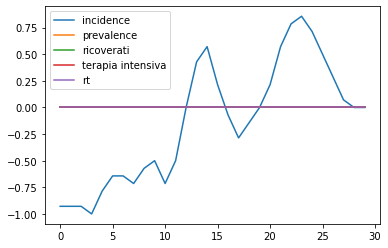

In [130]:
## AMD STUFF
stat = kendall_lag_correlation(applyfilter(df_amd, {"region" : [region_dict['Lazio']]}), dates_str_amd,
                               applyfilter(df_norm, {"denominazione_regione" : ['Lazio']}), dates_str_pc,
                               '2021-03-15', '2021-03-22', 30)

plt.plot(stat['driving']['incidence'], label = 'incidence')
plt.plot(stat['driving']['prevalence'], label = 'prevalence')
plt.plot(stat['driving']['ricoverati'], label = 'ricoverati')
plt.plot(stat['driving']['terapia_in'], label = 'terapia intensiva')
plt.plot(stat['driving']['rt'], label = 'rt')
plt.legend()

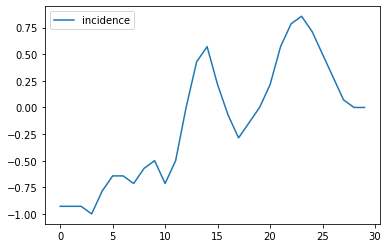

In [131]:
## GMD STUFF
stat_GMD = kendall_lag_correlation_GMD(applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD['Lazio']]}), dates_str_gmd,
                                       applyfilter(df_norm, {"denominazione_regione" : ['Lazio']}), dates_str_pc,
                                       '2021-03-15', '2021-03-22', 30)

plt.plot(stat_GMD['residential']['incidence'], label = 'incidence')
#plt.plot(stat_GMD['residential']['prevalence'], label = 'prevalence')
#plt.plot(stat_GMD['residential']['ricoverati'], label = 'ricoverati')
#plt.plot(stat_GMD['residential']['terapia_in'], label = 'terapia intensiva')
#plt.plot(stat_GMD['residential']['rt'], label = 'rt')
plt.legend()

In [39]:
## DEPRECATED


#for region in actual_regions:

#    fig, ax = plt.subplots(2,2, figsize=[20,12])
#    actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))

#    for ix,color in enumerate(actual_dict.keys()):
#        for pair in actual_dict[color]:
#            start, stop = pair
#            if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
#                try :
#                    stat = kendall_lag_correlation(applyfilter(df_amd, {"region" : [region_dict[region]]}), dates_str_amd,
#                                           applyfilter(df_pc, {"denominazione_regione" : [region]}), dates_str_pc,
#                                           applyfilter(df_rt, {"denominazione_regione" : [region]}), dates_str_rt,
#                                           start, stop, 30)
#                    ax[ix//2, ix%2].plot(stat['driving']['incidence'], label = pair)
#                    ax[ix//2, ix%2].plot(stat['driving']['rt'], '--', label = pair)
#                    #ax[ix//2, ix%2].plot(stat['walking']['incidence'], '--', label = pair)
#                    ax[ix//2, ix%2].set_title(color)
#                    ax[ix//2, ix%2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#                except Exception:
#                    pass
#    plt.suptitle(region)
#    plt.show()

#### Expanding previous function to consider also overall time windows
***

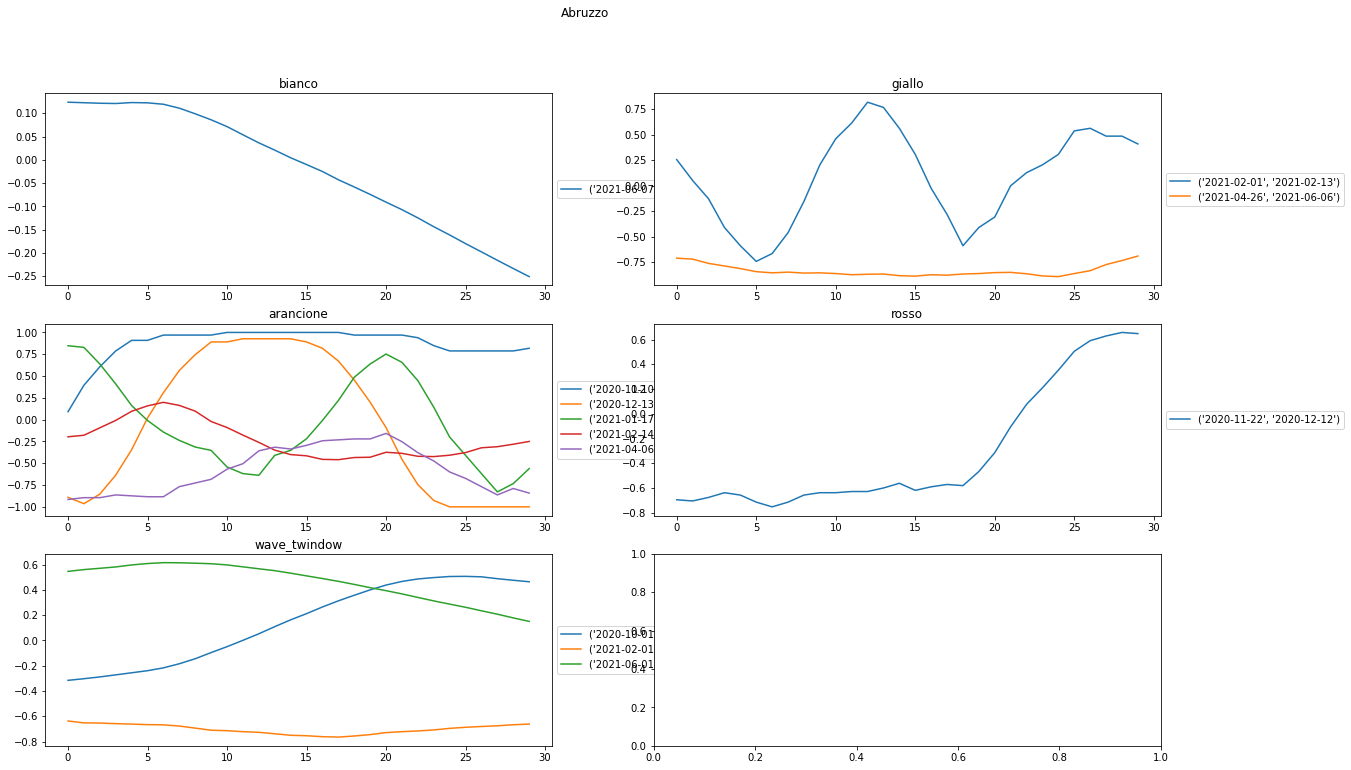

In [29]:
fixed_tw = None

for region in actual_regions:

    fig, ax = plt.subplots(3,2, figsize=[20,12])
    actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))
    actual_dict = {**actual_dict, **waves_dict}

    for ix,color in enumerate(actual_dict.keys()):
        for pair in actual_dict[color]:
            start, stop = pair            
            
            if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
                if (isinstance(fixed_tw, int)):
                    stop = fixed_tw
                try :
                    stat = kendall_lag_correlation(applyfilter(df_amd, {"region" : [region_dict[region]]}), dates_str_amd,
                                           applyfilter(df_norm, {"denominazione_regione" : [region]}), dates_str_pc,
                                           start, stop, 30)
                    ax[ix//2, ix%2].plot(stat['driving']['incidence'], label = pair)
                    #ax[ix//2, ix%2].plot(stat['driving']['rt'], '--', label = pair)
                    #ax[ix//2, ix%2].plot(stat['walking']['incidence'], '--', label = pair)
                    ax[ix//2, ix%2].set_title(color)
                    ax[ix//2, ix%2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
                except Exception:
                    pass
    plt.suptitle(region)
    plt.show()
    break

### Same function for GMD
***

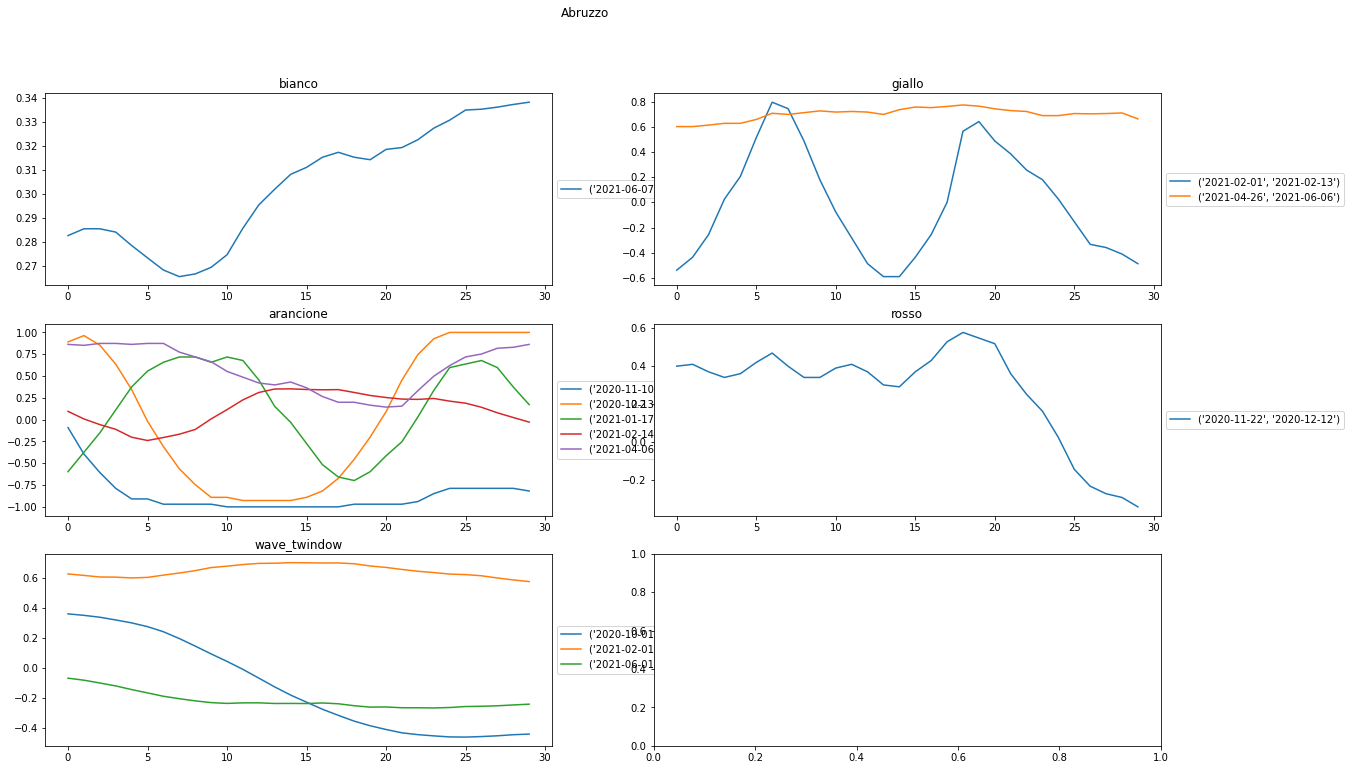

In [30]:
fixed_tw = None

for region in actual_regions:

    fig, ax = plt.subplots(3,2, figsize=[20,12])
    actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))
    actual_dict = {**actual_dict, **waves_dict}

    for ix,color in enumerate(actual_dict.keys()):
        for pair in actual_dict[color]:
            start, stop = pair            
            
            if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
                if (isinstance(fixed_tw, int)):
                    stop = fixed_tw
                try :
                    stat = kendall_lag_correlation_GMD(applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}), dates_str_gmd,
                                                       applyfilter(df_norm, {"denominazione_regione" : [region]}), dates_str_pc,
                                                       start, stop, 30)
                    ax[ix//2, ix%2].plot(stat['residential']['incidence'], label = pair)
                    #ax[ix//2, ix%2].plot(stat['driving']['rt'], '--', label = pair)
                    #ax[ix//2, ix%2].plot(stat['walking']['incidence'], '--', label = pair)
                    ax[ix//2, ix%2].set_title(color)
                    ax[ix//2, ix%2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
                except Exception:
                    pass
    plt.suptitle(region)
    plt.show()
    break

### Time evolution of lag

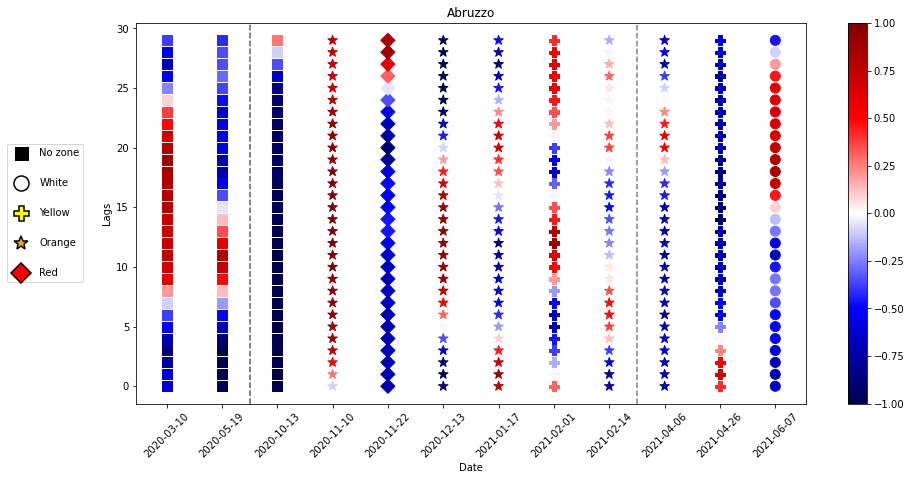

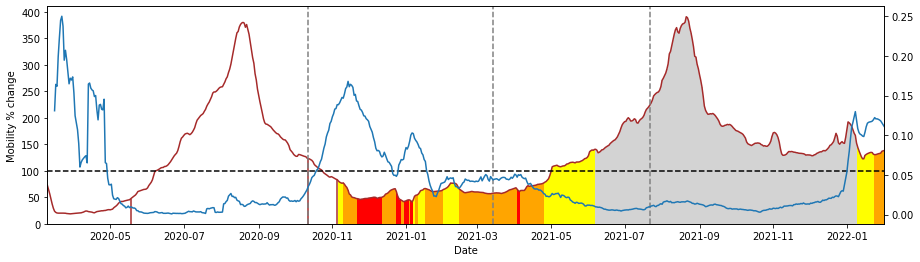

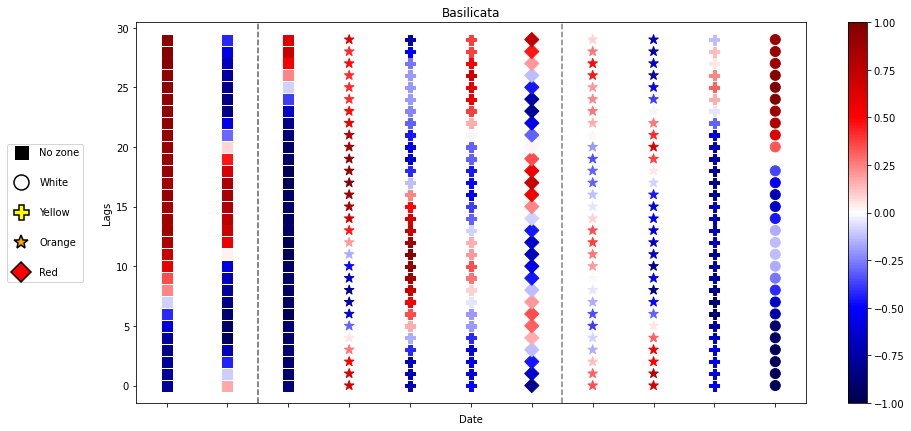

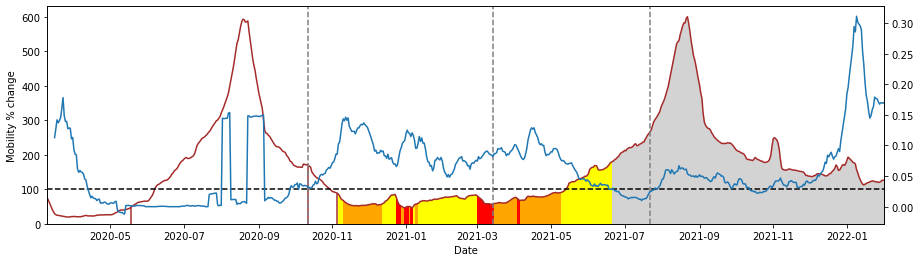

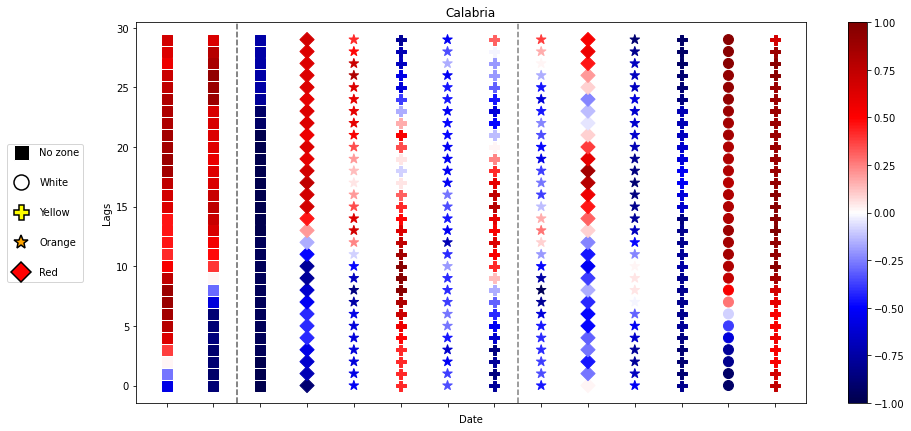

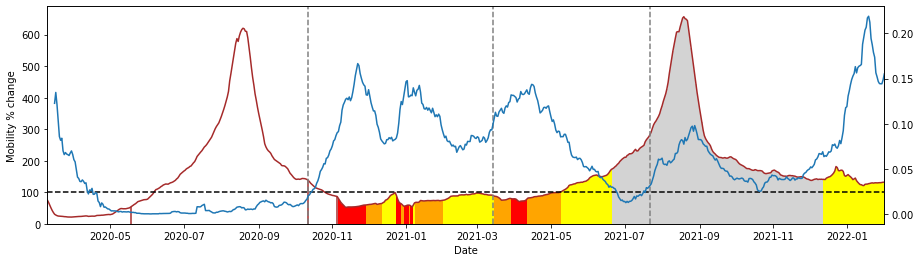

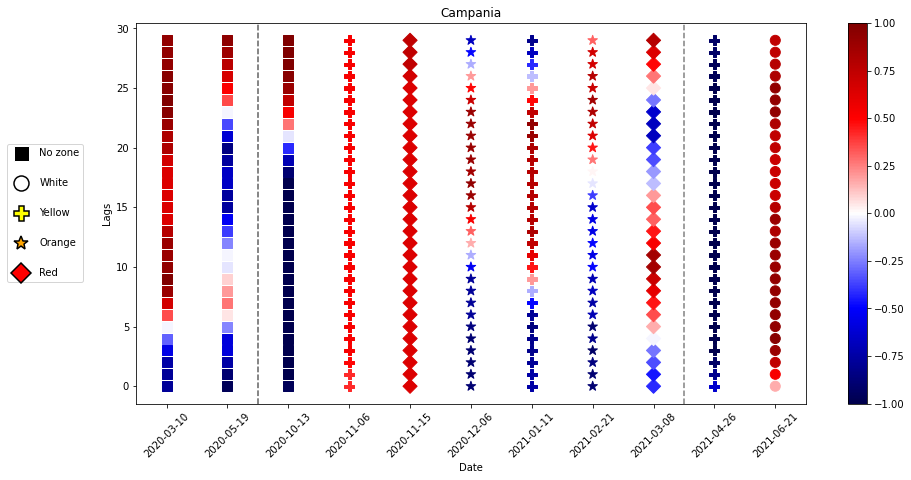

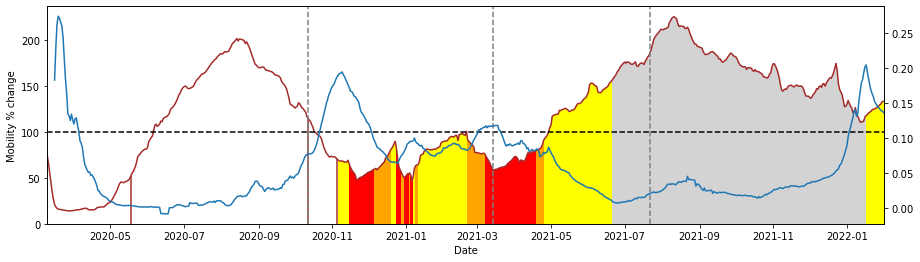

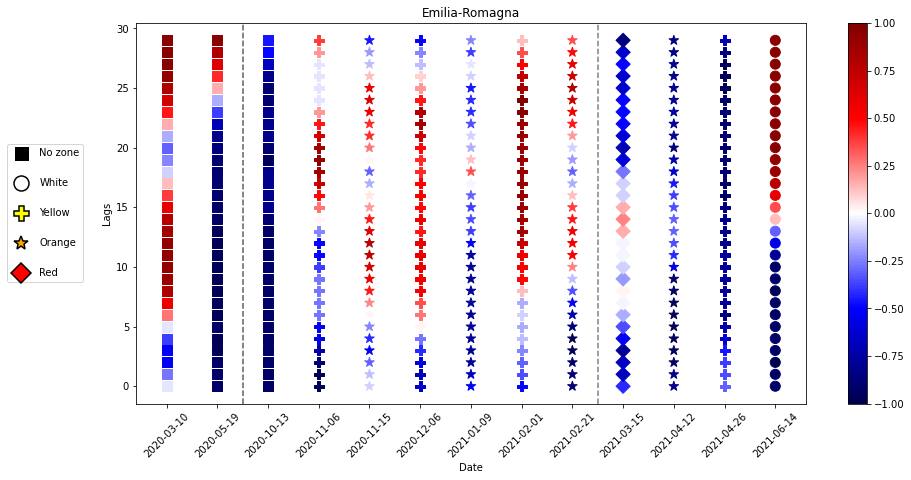

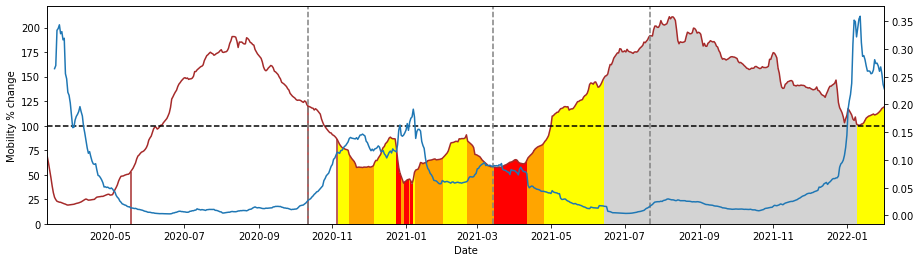

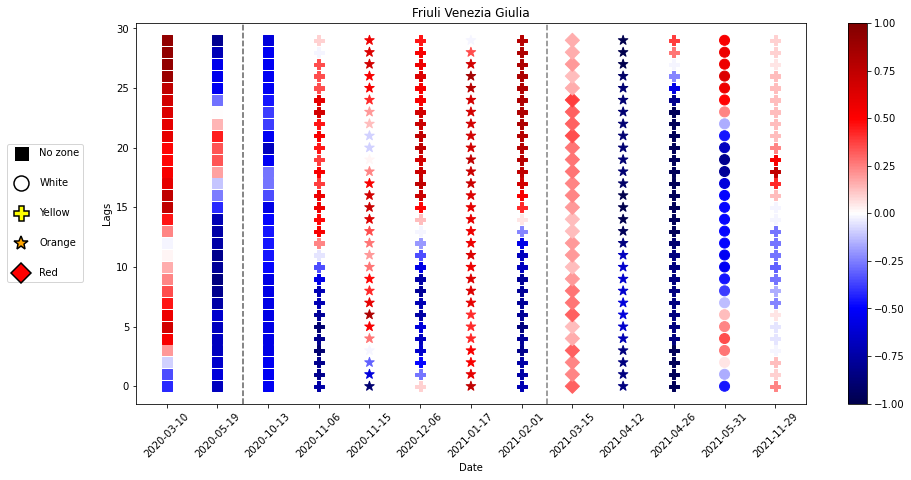

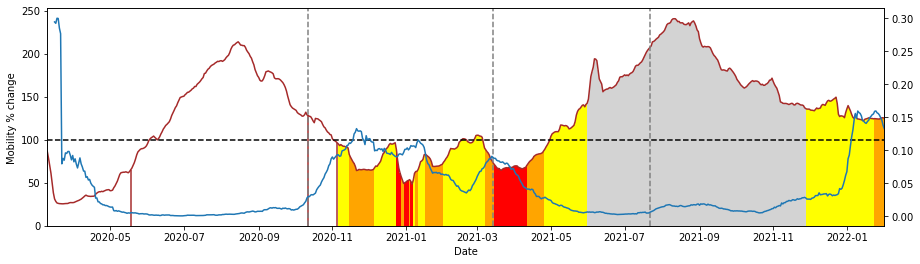

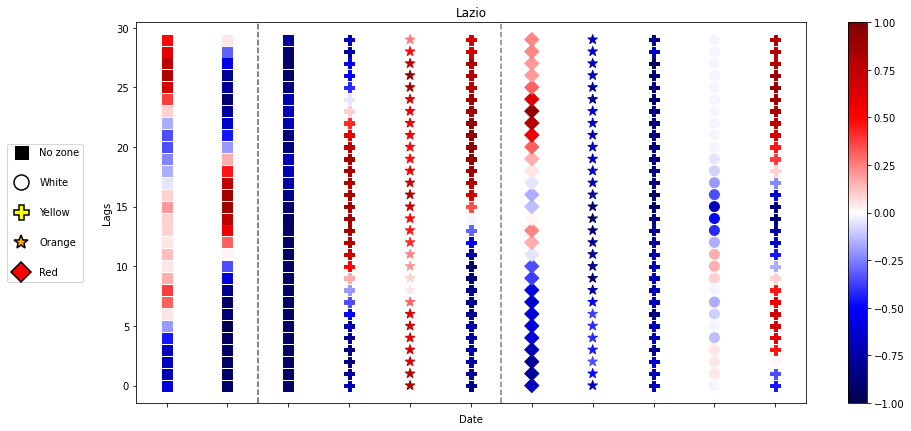

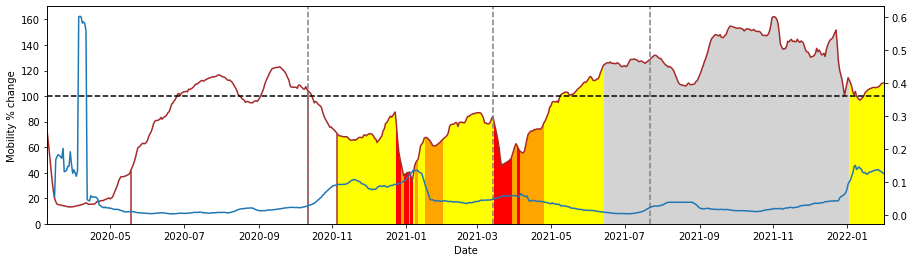

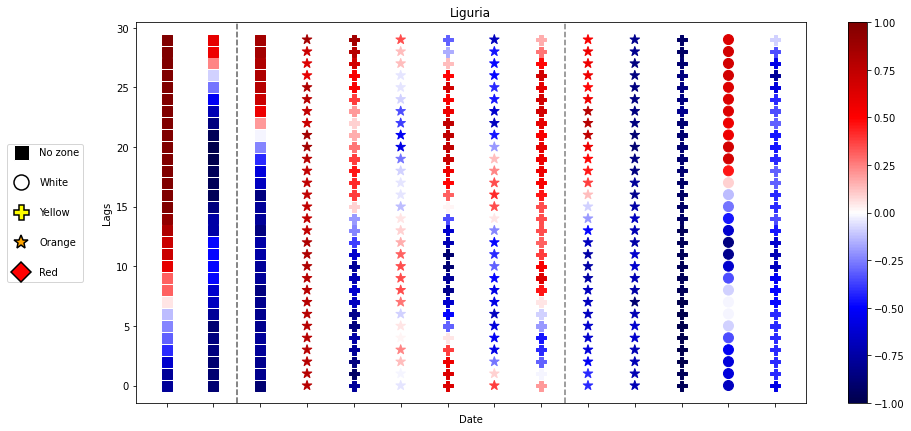

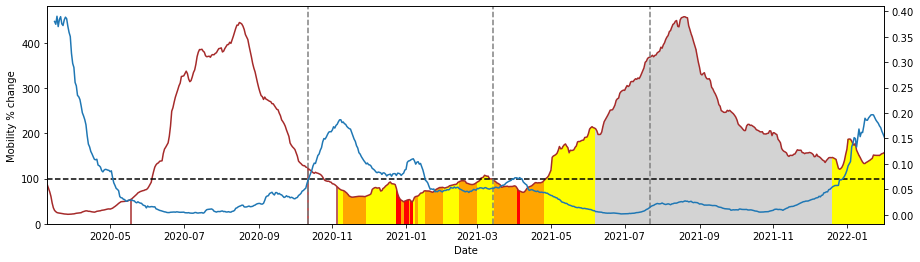

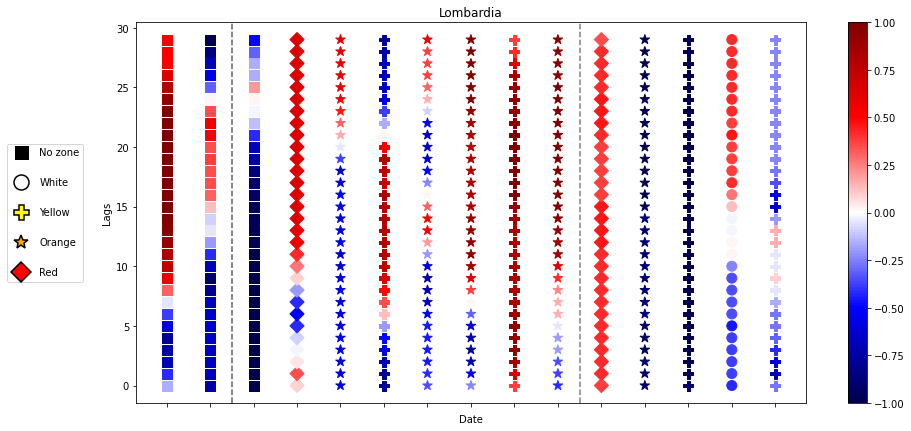

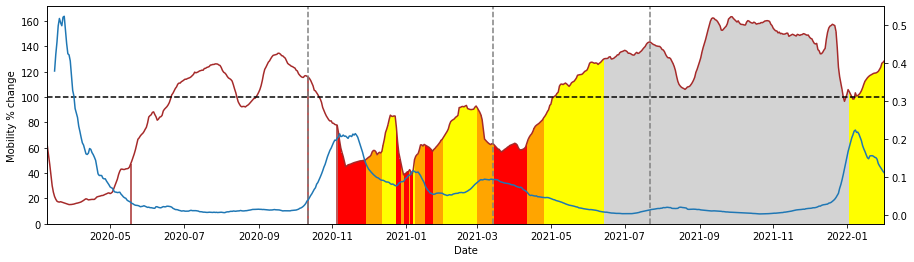

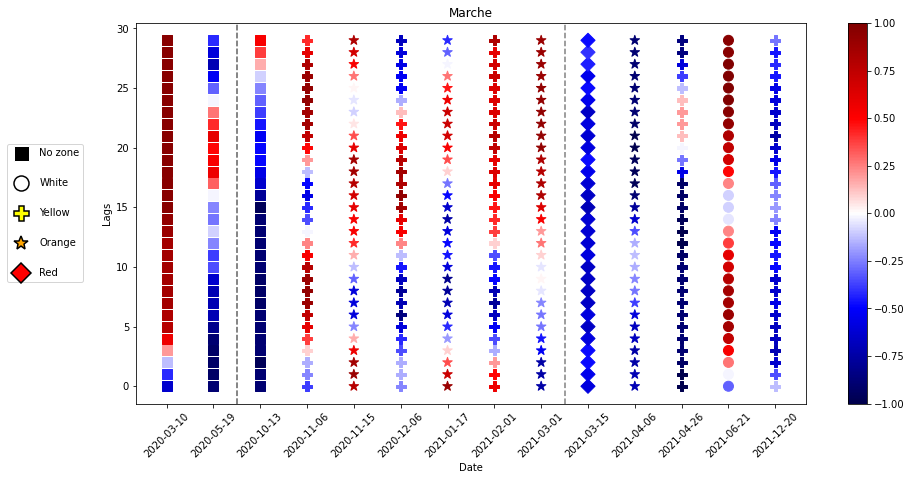

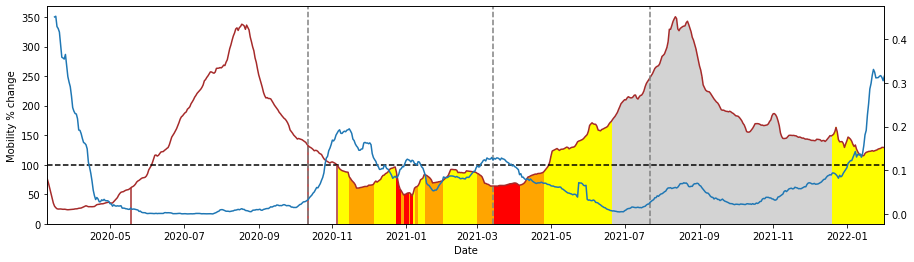

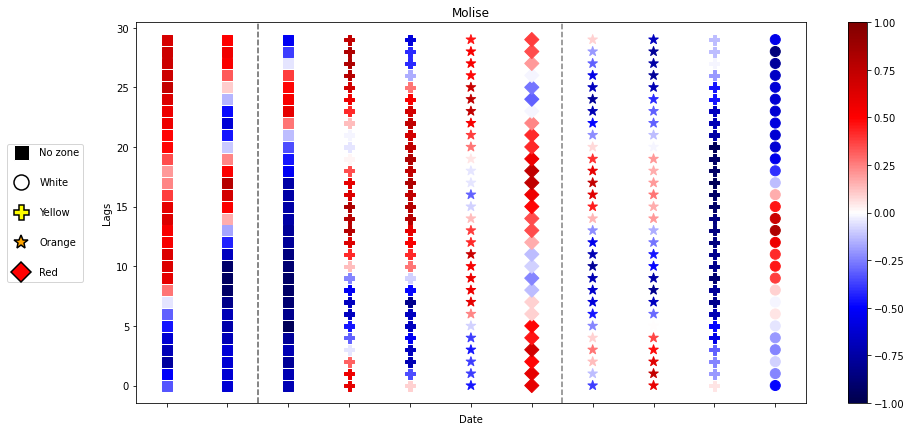

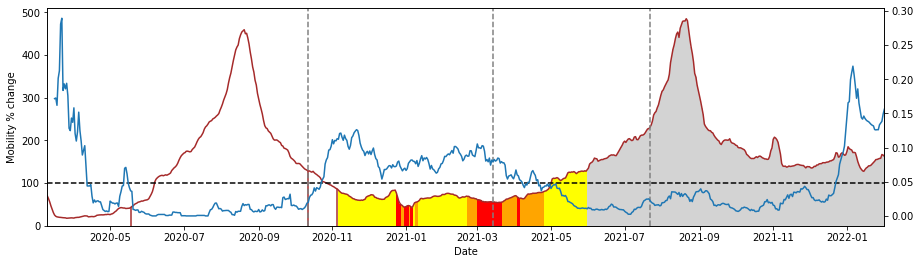

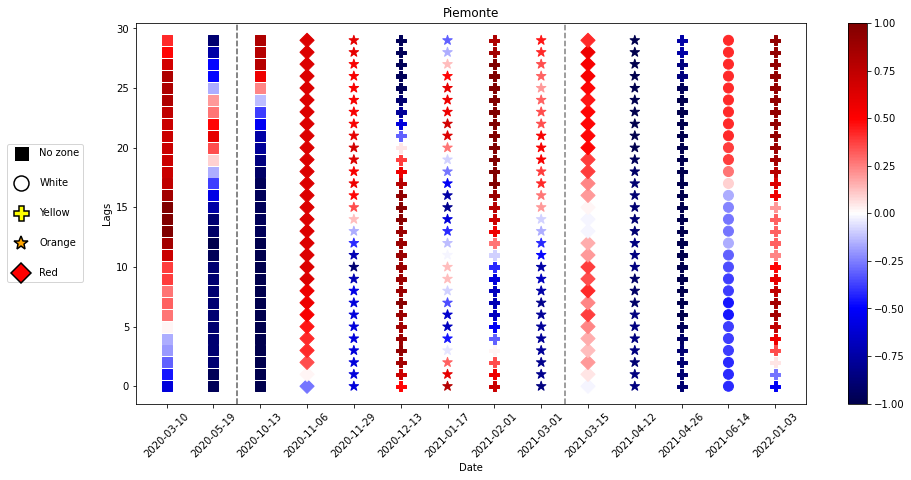

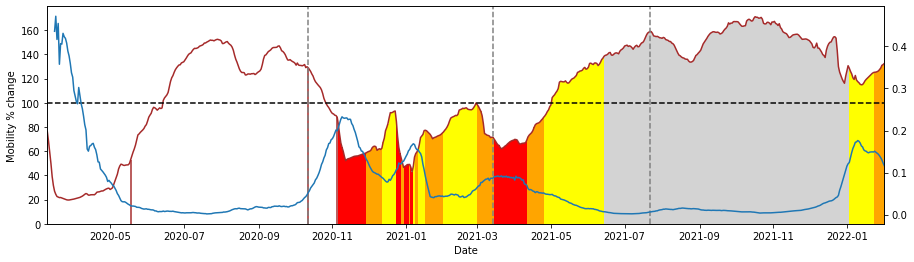

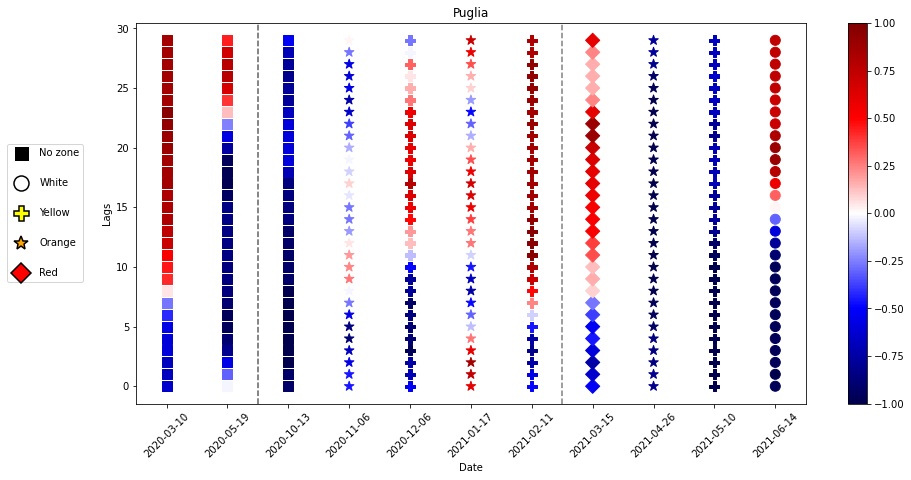

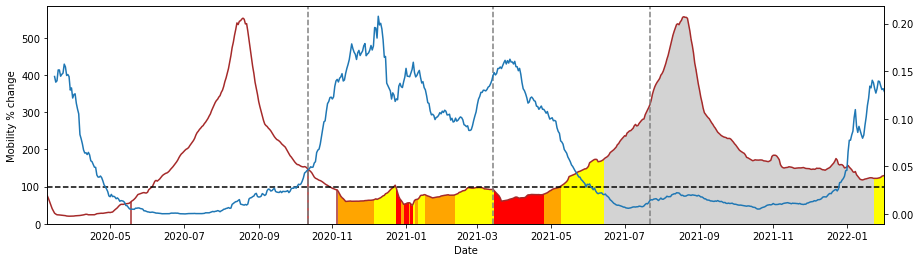

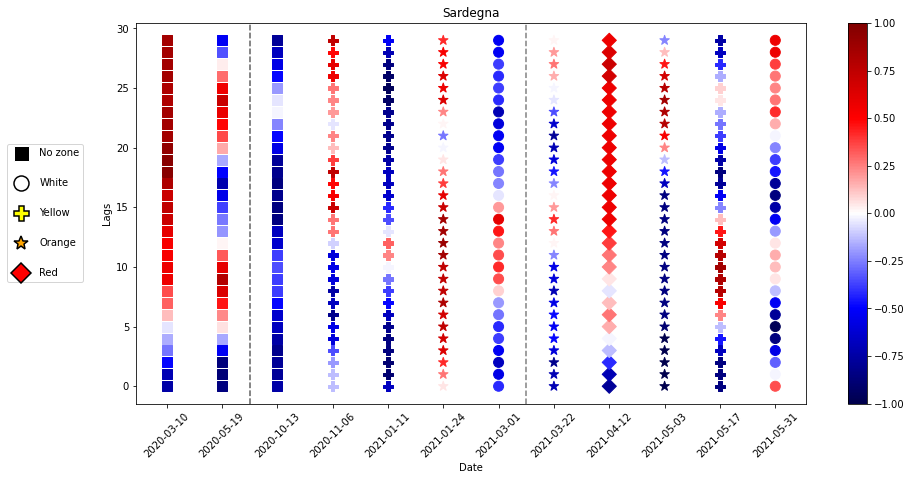

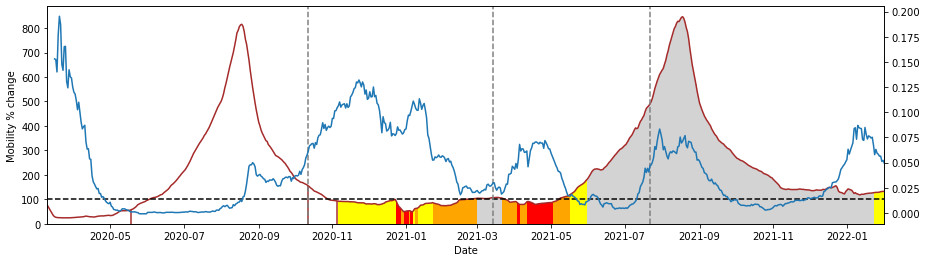

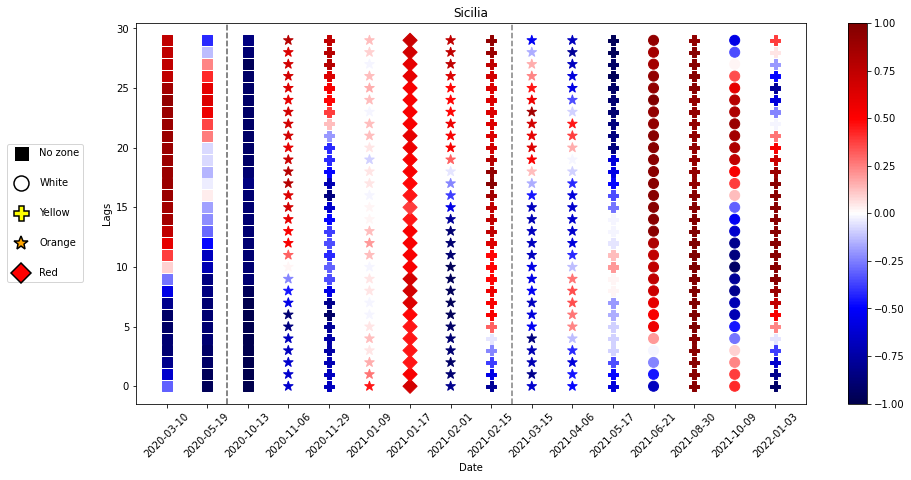

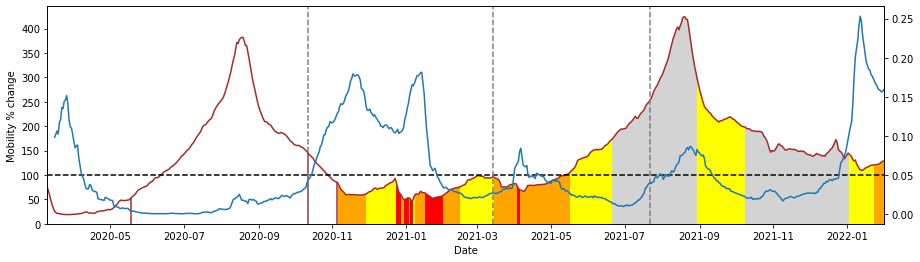

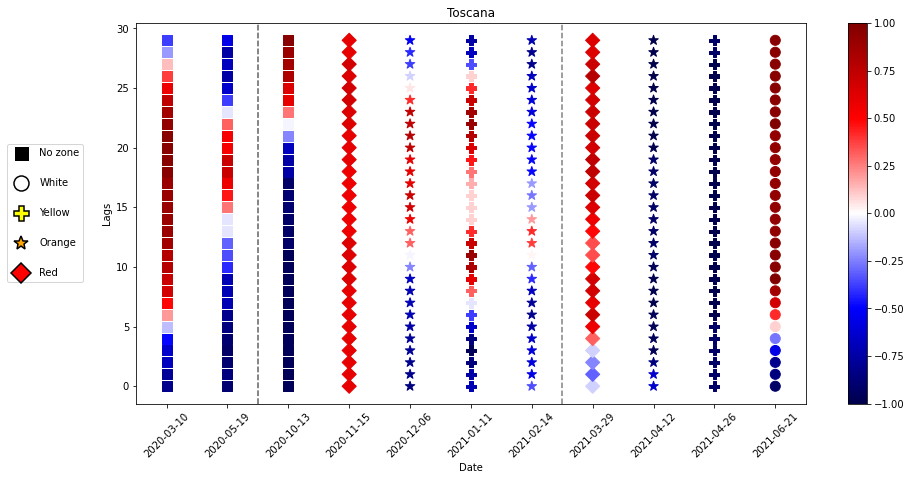

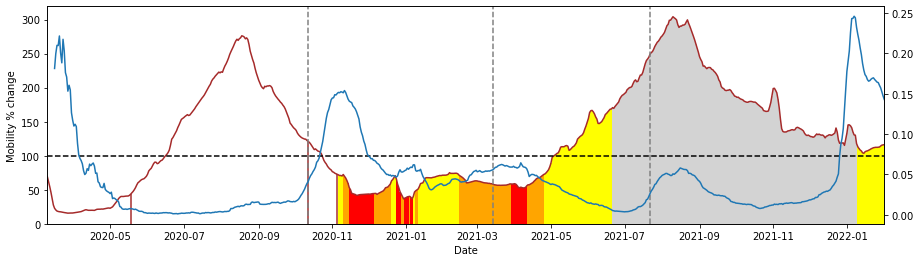

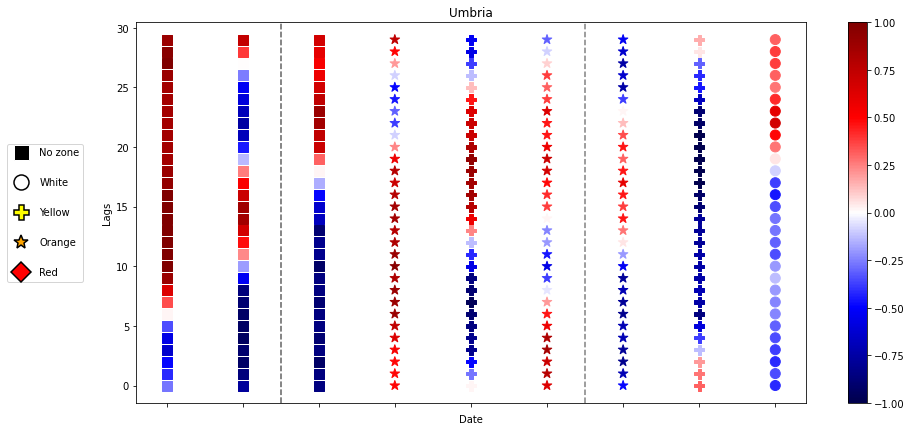

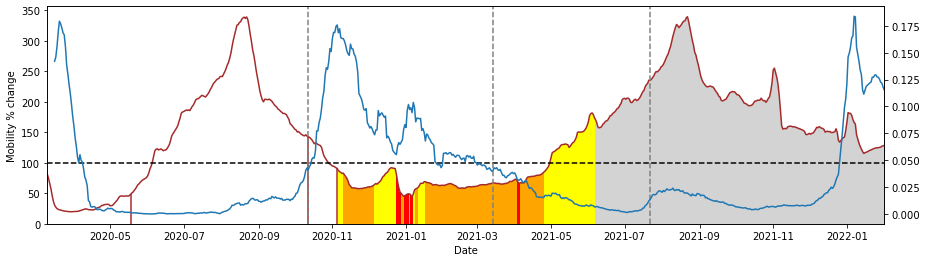

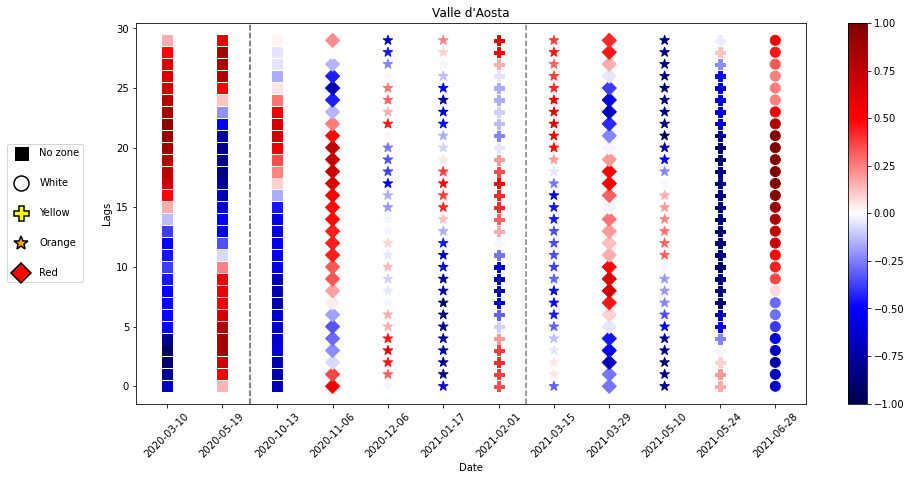

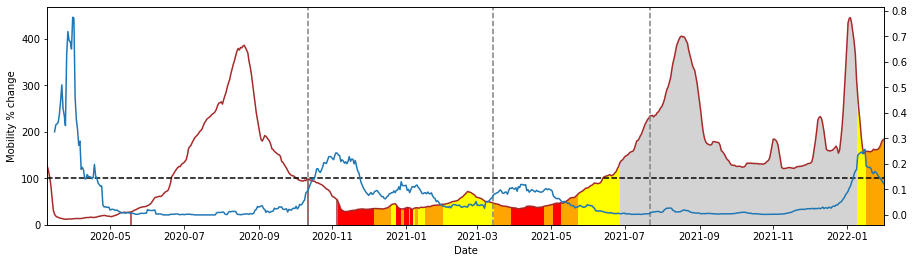

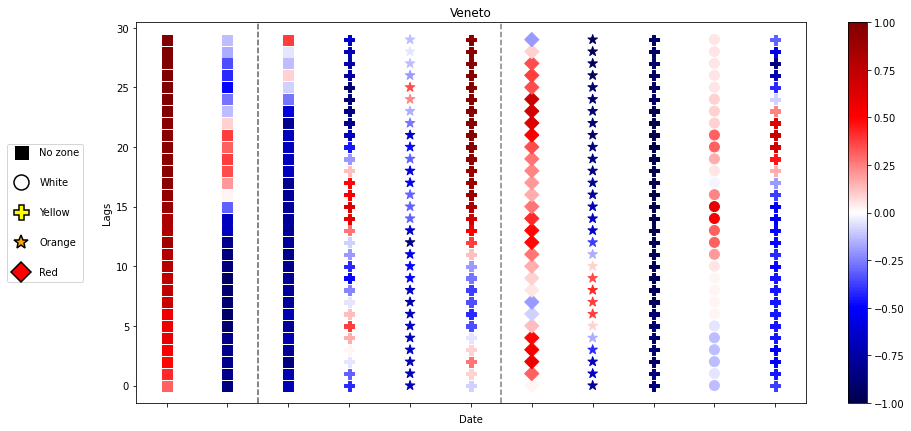

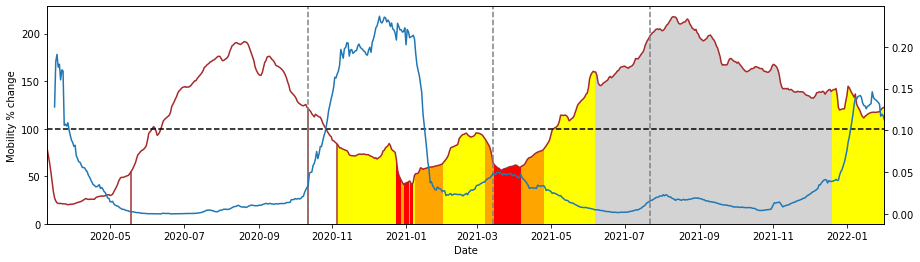

In [164]:
cmap = mpc.LinearSegmentedColormap.from_list("", ["darkblue","darkblue","blue","blue","blue",
                                                                "blue","blue","mediumslateblue","lightsteelblue","white",
                                                                "white","yellow","orange","red","red",
                                                                "red","red","red","darkred","darkred"])
marker_dict = {'no_zone'   : 's',
               'bianco'    : 'o',
               'giallo'    : 'P',
               'arancione' : '*',
               'rosso'     : 'D'}
legend_elements = [Line2D([0], [0], marker='s', color='w', label='No zone',
                          markerfacecolor='black', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='White',
                          markerfacecolor='w', markersize=15, markeredgewidth=1.5, 
                          markeredgecolor='black'),
                   Line2D([0], [0], marker='P', color='w', label='Yellow',
                          markerfacecolor='yellow', markersize=15, markeredgewidth=1.5, 
                          markeredgecolor='black'),
                   Line2D([0], [0], marker='*', color='w', label='Orange',
                          markerfacecolor='orange', markersize=15, markeredgewidth=1.5, 
                          markeredgecolor='black'),
                   Line2D([0], [0], marker='D', color='w', label='Red',
                          markerfacecolor='red', markersize=14, markeredgewidth=1.5, 
                          markeredgecolor='black')]
#  13 ottobre divieto di assembramento
waves_dict_ita = {'no_zone': [('2020-03-10', '2020-05-18'),
                              ('2020-05-19', '2020-10-12'),
                              ('2020-10-13', '2020-11-05')]} #iniziano divieti di assembramento
fixed_tw = 10


for region in actual_regions:

    plt.figure(figsize=[15,7])
    actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))
    actual_dict = {**actual_dict, **waves_dict_ita}
    ticks_datetime_list = [datetime.datetime.strptime(start[0], "%Y-%m-%d").date() \
                           for start in [i for j in list(actual_dict.values()) for i in j] \
                           if ((datetime.datetime.strptime(start[1], "%Y-%m-%d").date() - datetime.datetime.strptime(start[0], "%Y-%m-%d").date()).days >=7)]
    ticks_datetime_list.sort()
    counter = 0

    for ix,color in enumerate(actual_dict.keys()):
        for pair in actual_dict[color]:
            start, stop = pair            
            
            if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
                if (isinstance(fixed_tw, int)):
                    stop = fixed_tw
                try :
                    stat = kendall_lag_correlation(applyfilter(df_amd, {"region" : [region_dict[region]]}), dates_str_amd,
                                           applyfilter(df_norm, {"denominazione_regione" : [region]}), dates_str_pc,
                                           start, stop, 30)
                    #plt.scatter(x=[datetime.datetime.strptime(start, "%Y-%m-%d").date()]*30,
                    #         y=np.arange(30), c=stat['driving']['incidence'], 
                    #         vmin=-1, vmax=1, cmap=cmap, label = color)
                    #ax[ix//2, ix%2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.scatter(x=[ticks_datetime_list.index(datetime.datetime.strptime(start, "%Y-%m-%d").date())]*30,
                             y=np.arange(30), c=stat['driving']['incidence'], 
                             vmin=-1, vmax=1, cmap='seismic', marker=marker_dict[color], s=100)
                except Exception:
                    #pass
                    counter+=1
    plt.colorbar()
    plt.title(region)
    plt.ylabel('Lags')
    plt.xlabel('Date')
    plt.xticks(range(len(ticks_datetime_list)-counter), ticks_datetime_list[:-counter], rotation=45)
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(-0.2,0.5), labelspacing=2)
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max)
    plt.vlines([[data > datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True) - 0.5,
                [data > datetime.datetime.strptime('2021-03-14', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True) - 0.5,
                [data > datetime.datetime.strptime('2020-07-22', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True) - 0.5], 
                 y_min, y_max, ls='--', colors='gray')
    plt.show()
    
    fig, ax1 = plt.subplots(figsize=(15,4))
    start_date = "2020-03-10"
    start_col_date = "2020-11-06"
    end_date   = "2022-02-01"
    slice_mob, mask_mob = from_to(dates_str_amd, start_date, end_date)
    slice_mob_c, mask_mob_c = from_to(dates_str_amd, start_col_date, end_date)
    slice_col, mask_col = from_to(applyfilter(colors, {'denominazione_regione' : [region]}).data.values, start_col_date, end_date)
    slice_inc, mask_inc = from_to(dates_str_pc, start_date, end_date)
    translate = {'bianco'    : 'lightgray',
                 'giallo'    : 'yellow',
                 'arancione' : 'orange',
                 'rosso'     : 'red'}
    color_list = [translate[col] for col in applyfilter(colors, {'denominazione_regione' : [region]}).colore.values]
    ax2 = ax1.twinx()
    #ax1.vlines(datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date(), y_min, y_max, '--')
    ax1.plot(dates_datetime_amd[slice_mob], applyfilter(df_amd, {"region" : [region_dict[region]]}).iloc[0, mask_mob+2].values,
             label="AMD", color='brown')
    ax1.bar(dates_datetime_amd[slice_mob_c], applyfilter(df_amd, {"region" : [region_dict[region]]}).iloc[0, mask_mob_c+2].values,
             label="AMD", color=color_list[slice_col], width=1)
    ax2.plot(dates_datetime_pc[slice_inc], applyfilter(df_norm, {"denominazione_regione" : [region]}).iloc[mask_inc,31].rolling(window=7).mean(), 
             label="Normalized incidence")
    ax1.plot([dates_datetime_amd[slice_mob][0], dates_datetime_amd[slice_mob][-1]], [100,100], '--', color='black')
    y_min, y_max = ax1.get_ylim()
    #ax1.vlines([datetime.datetime.strptime('2020-05-18', "%Y-%m-%d").date(),
    #            datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date(),
    #            datetime.datetime.strptime('2020-11-05', "%Y-%m-%d").date()], y_min, y_max, ls='--', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-05-18', "%Y-%m-%d").date()], 
                y_min, applyfilter(df_amd, {"region" : [region_dict[region]]}).loc[:, '2020-05-18'].values[0], ls='-', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date()], 
                y_min, applyfilter(df_amd, {"region" : [region_dict[region]]}).loc[:, '2020-10-12'].values[0], ls='-', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-11-05', "%Y-%m-%d").date()], 
                y_min, applyfilter(df_amd, {"region" : [region_dict[region]]}).loc[:, '2020-11-05'].values[0], ls='-', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date(),
                datetime.datetime.strptime('2021-03-14', "%Y-%m-%d").date(),
                datetime.datetime.strptime('2021-07-22', "%Y-%m-%d").date()], y_min, y_max, ls='--', colors='gray')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mobility % change')
    ax1.set_xlim(dates_datetime_amd[slice_mob][0], dates_datetime_amd[slice_mob][-1])
    ax1.set_ylim(y_min, y_max)
    #plt.legend()
    #ax2.set_ylabel('Y2 data', color='b')

    plt.show()
    #break

In [94]:
[data > datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True)

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

## Same function for GMD
***

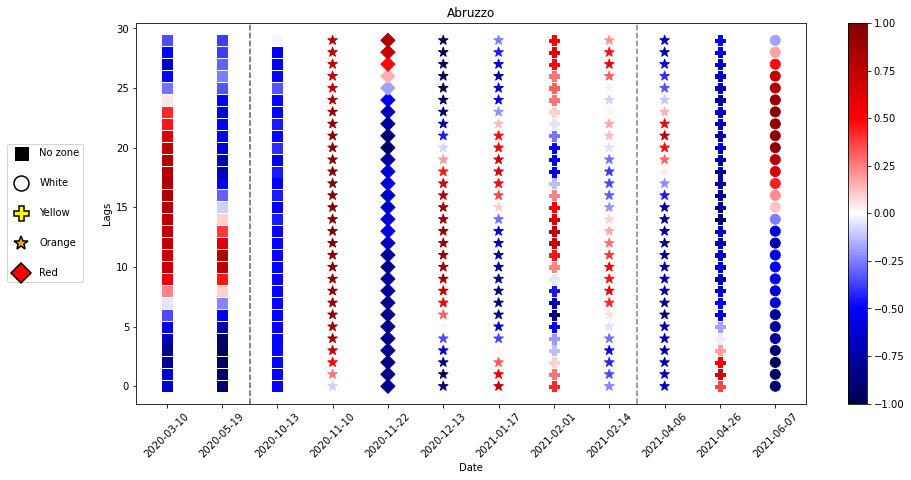

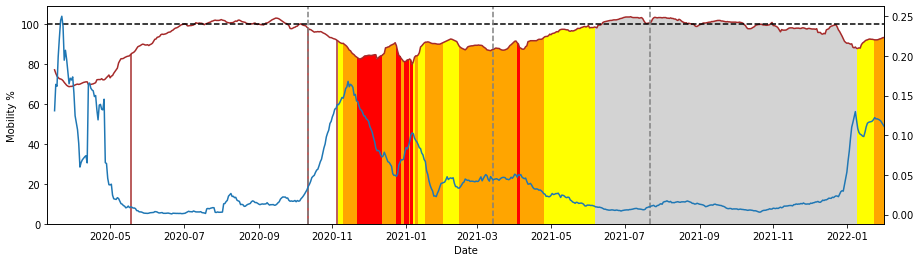

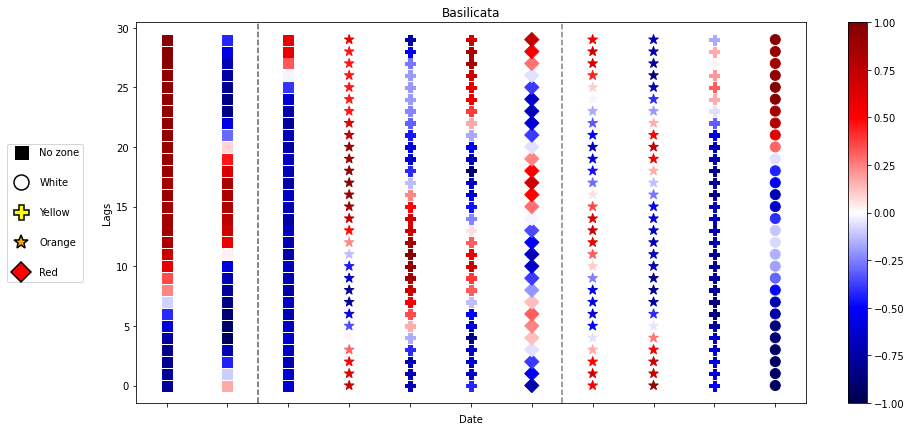

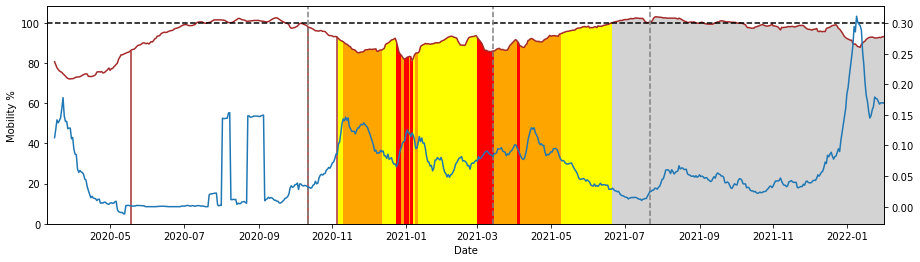

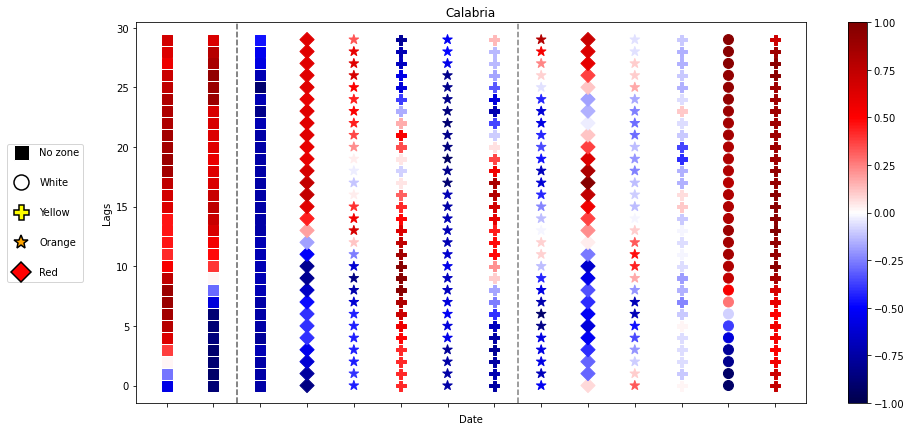

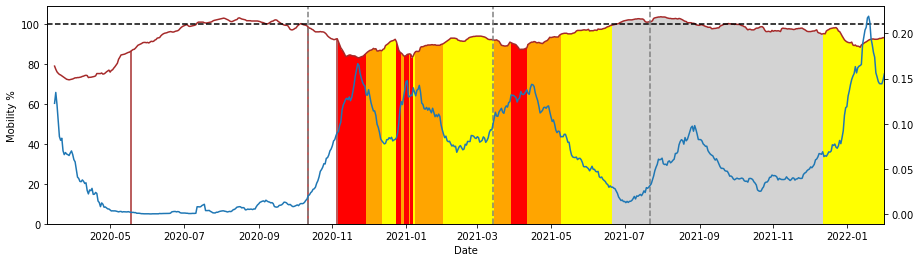

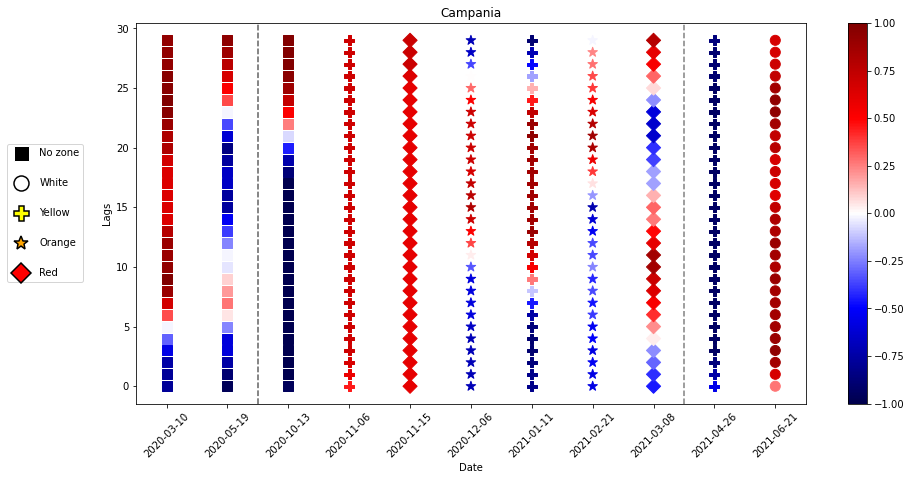

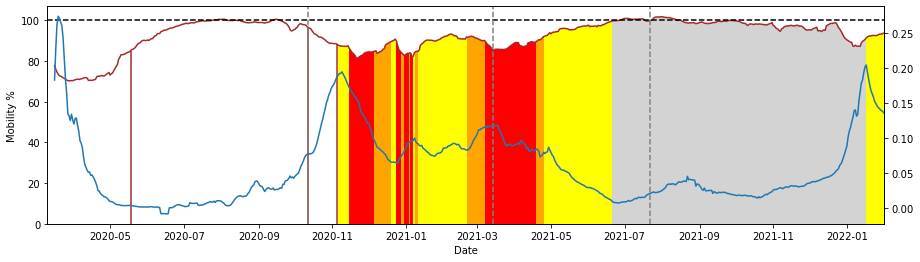

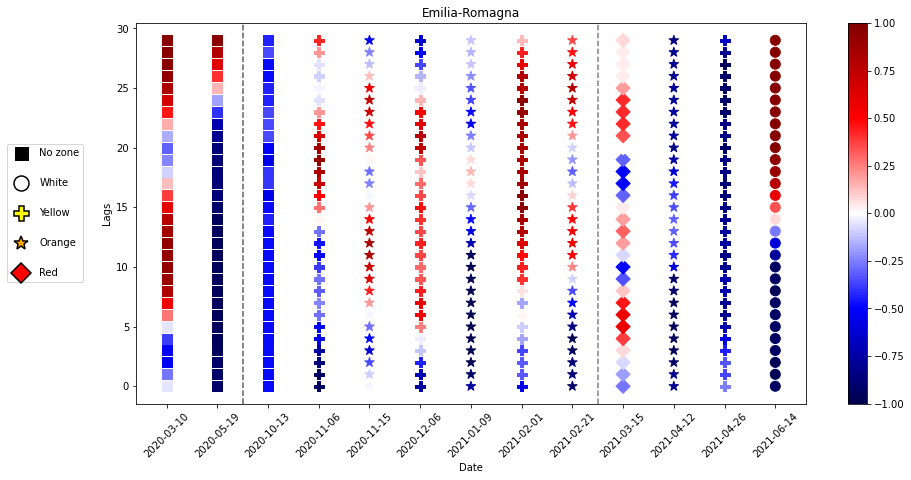

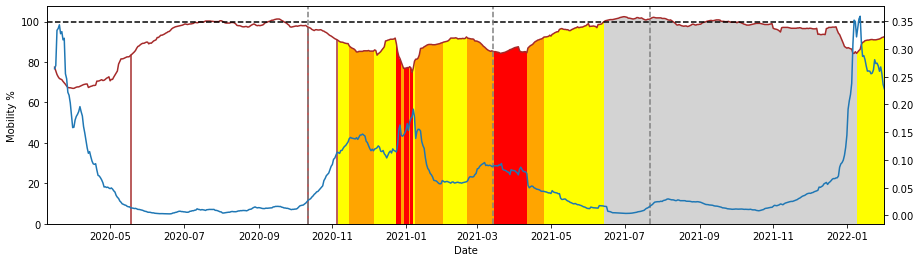

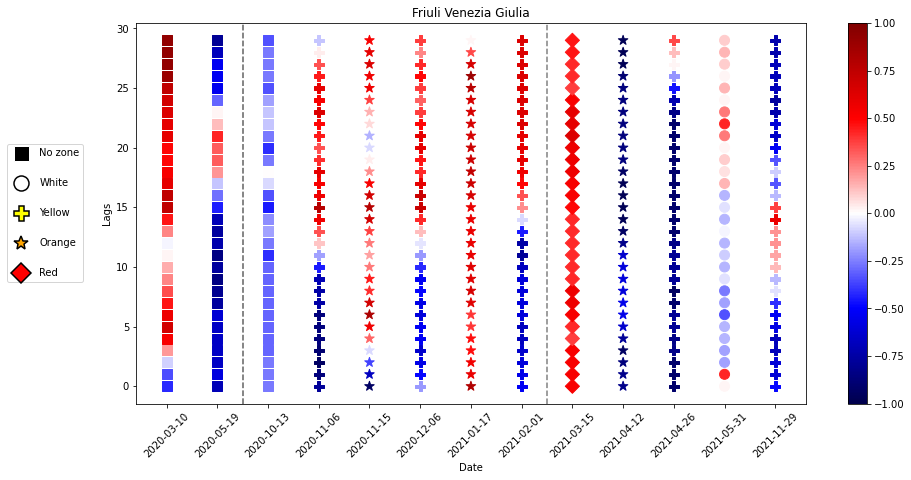

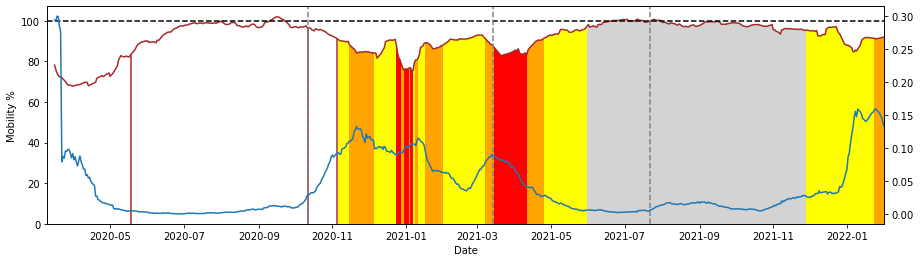

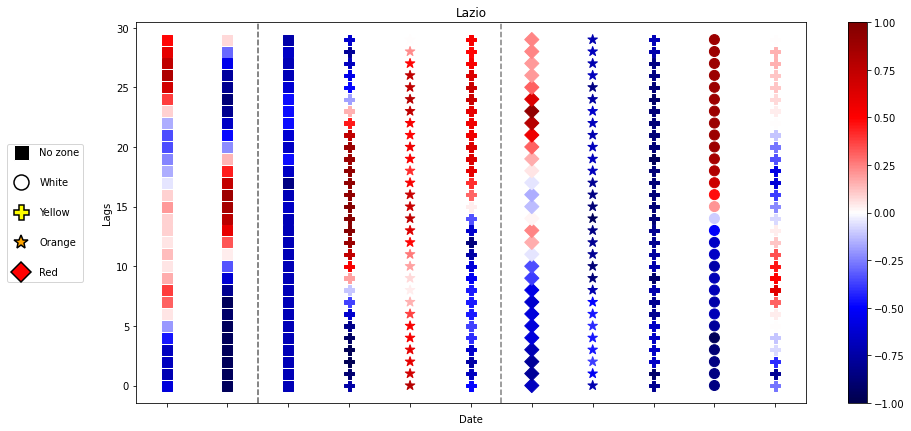

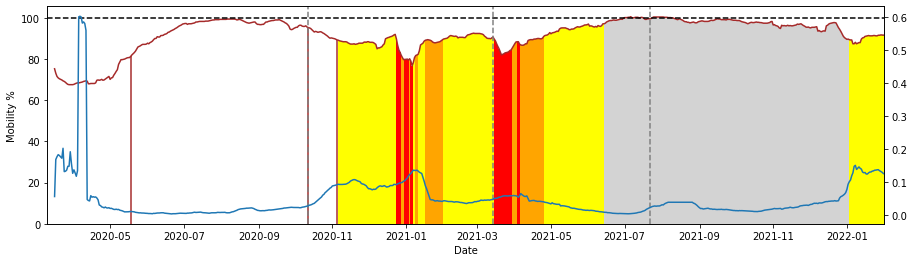

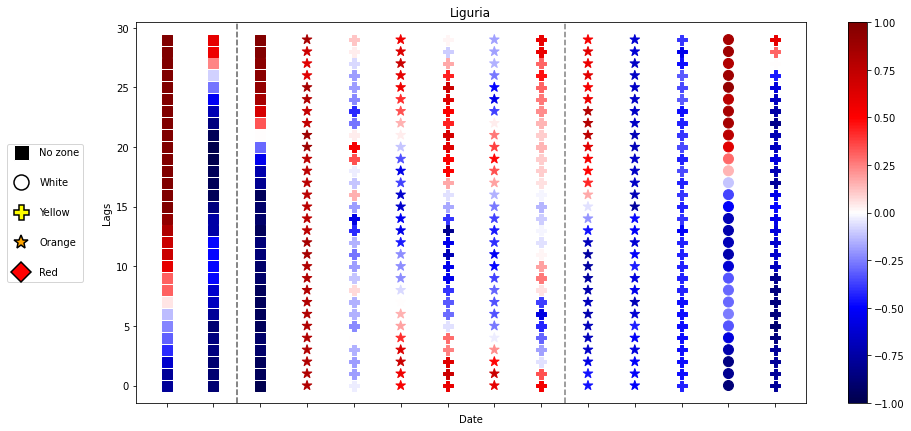

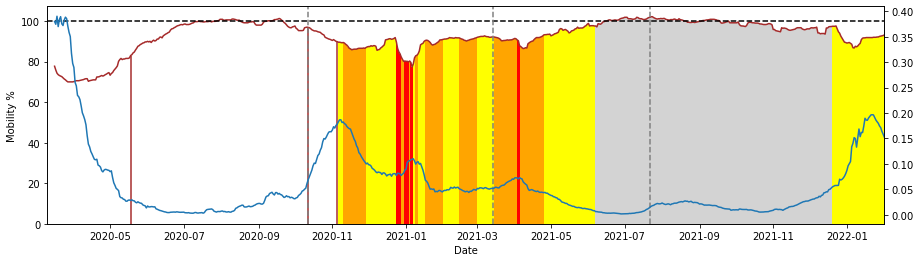

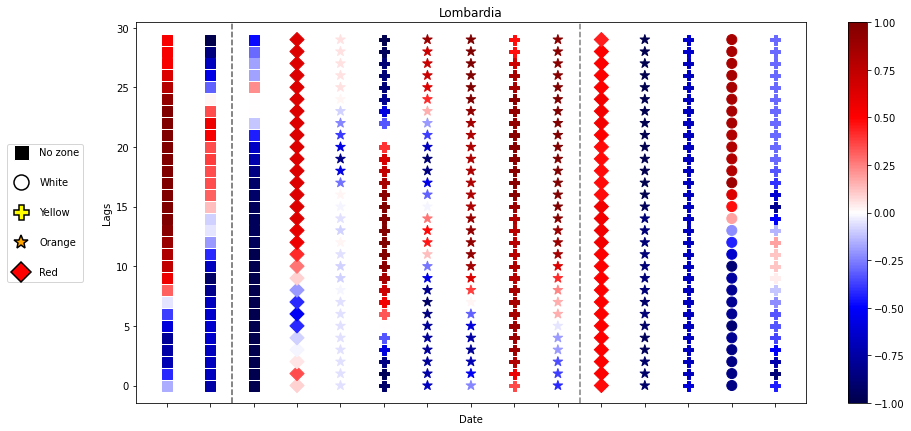

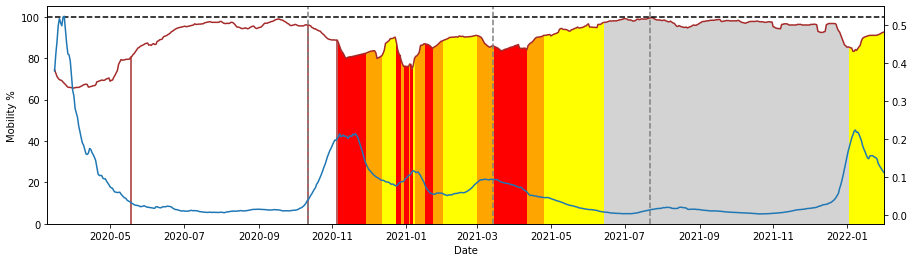

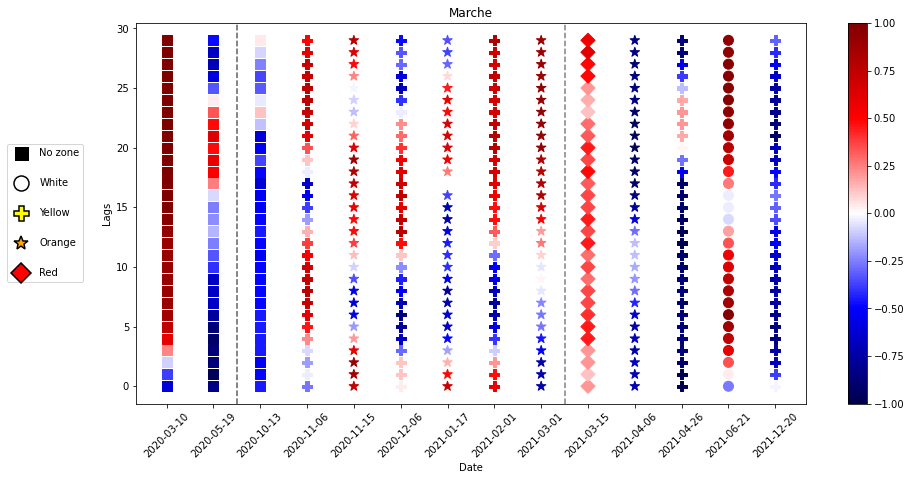

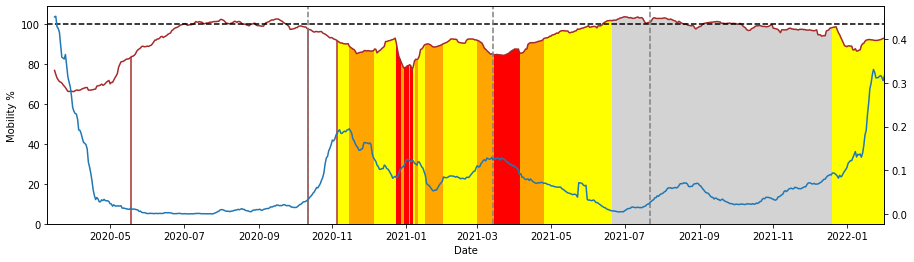

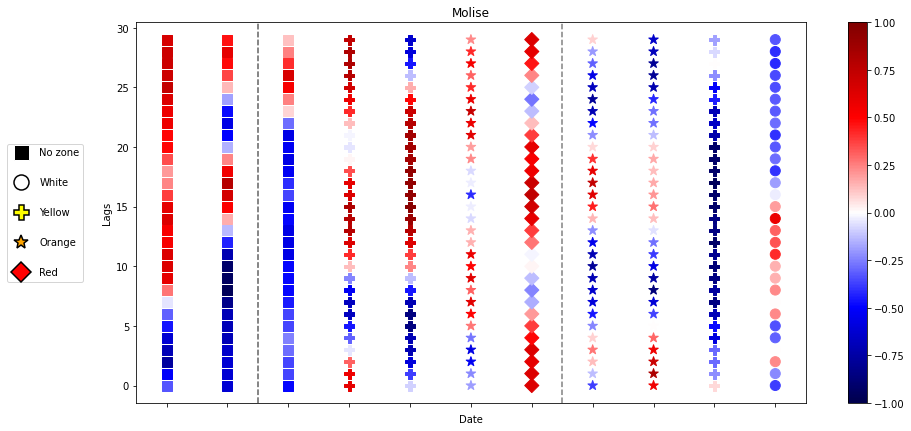

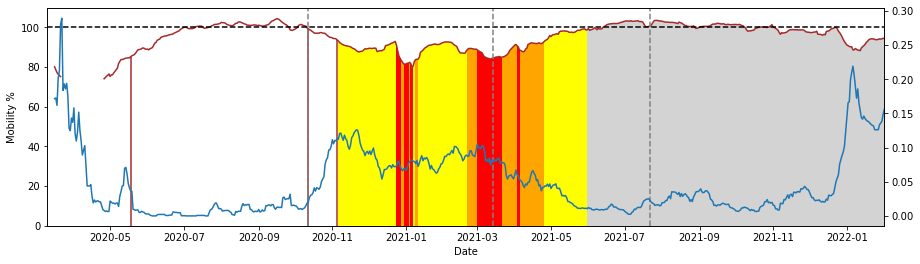

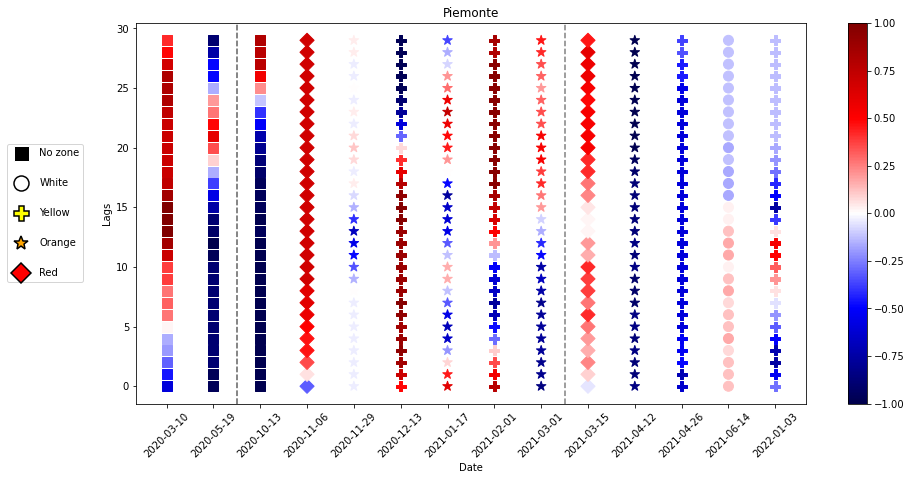

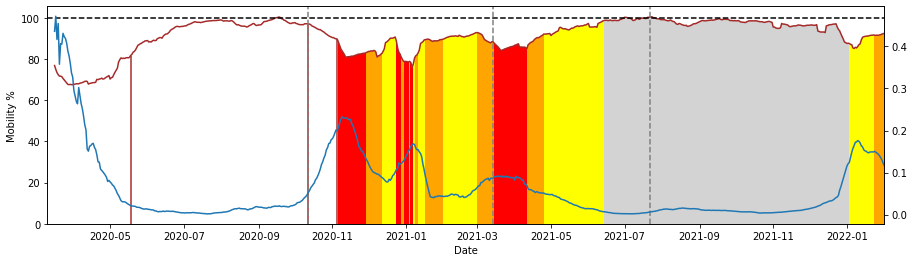

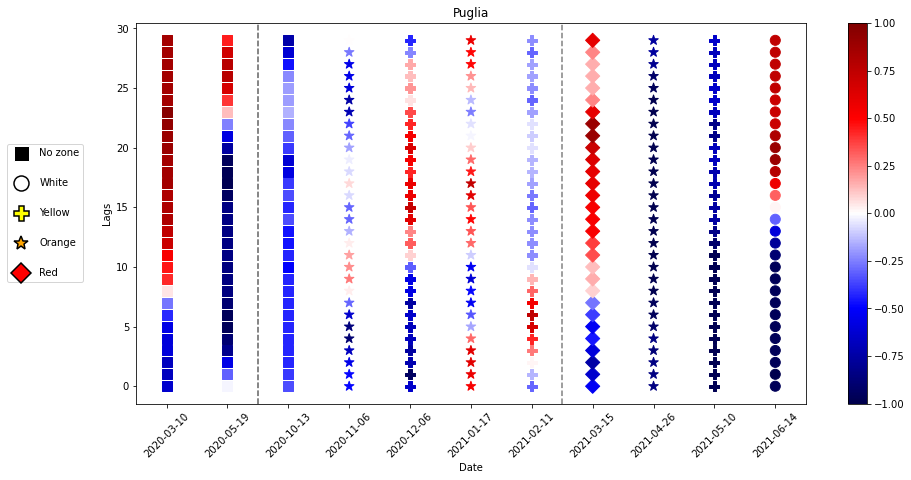

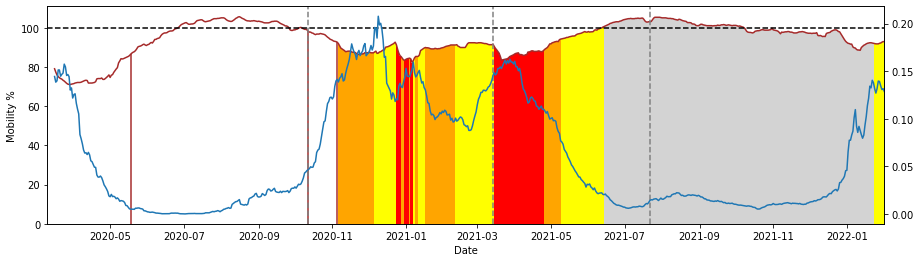

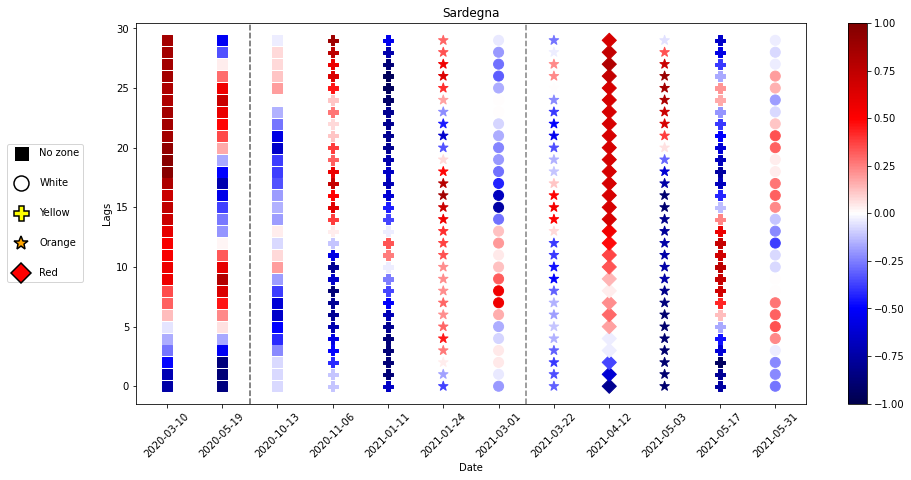

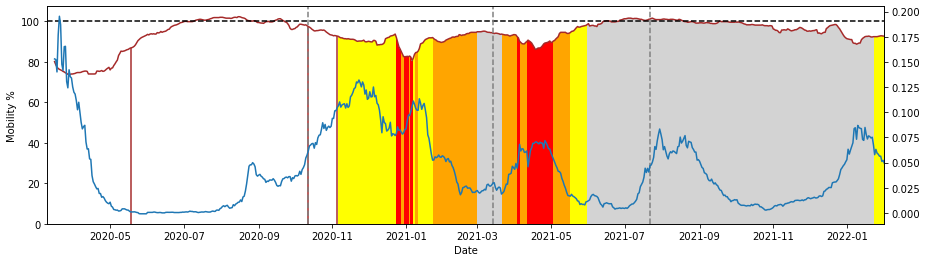

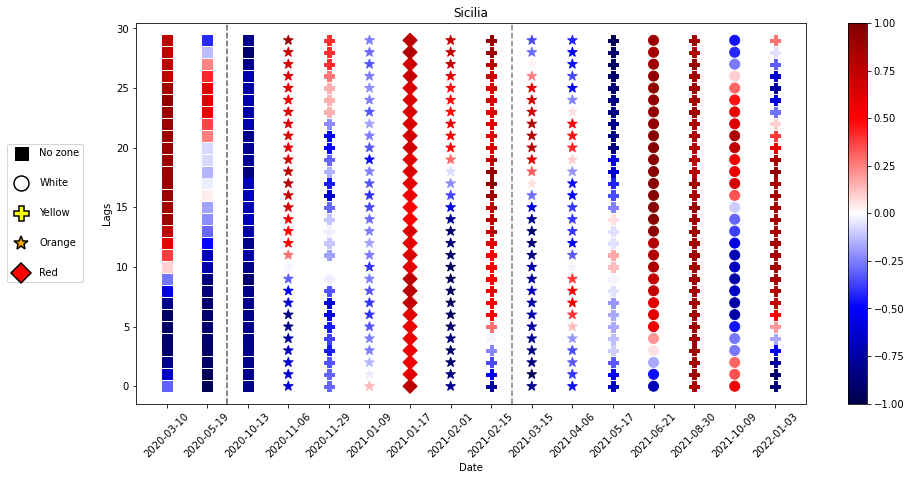

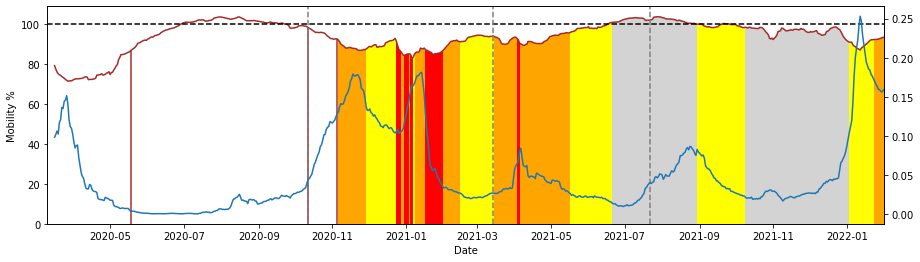

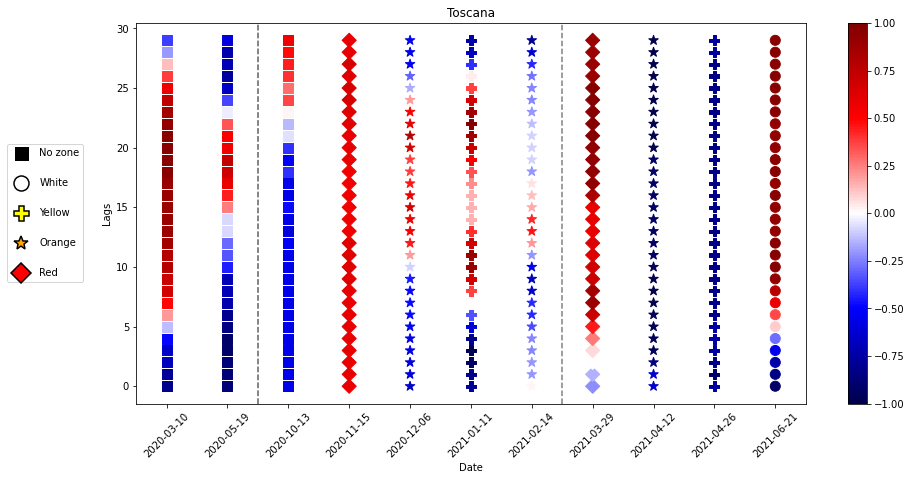

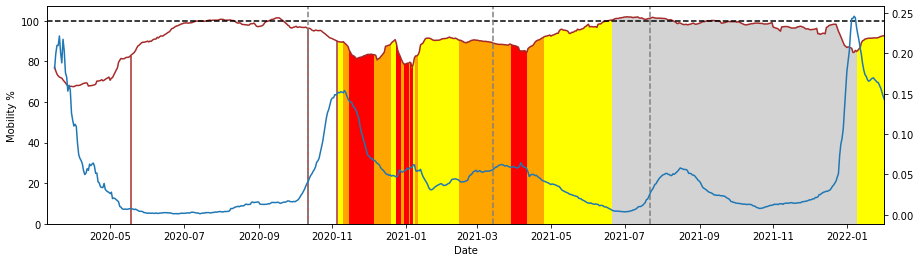

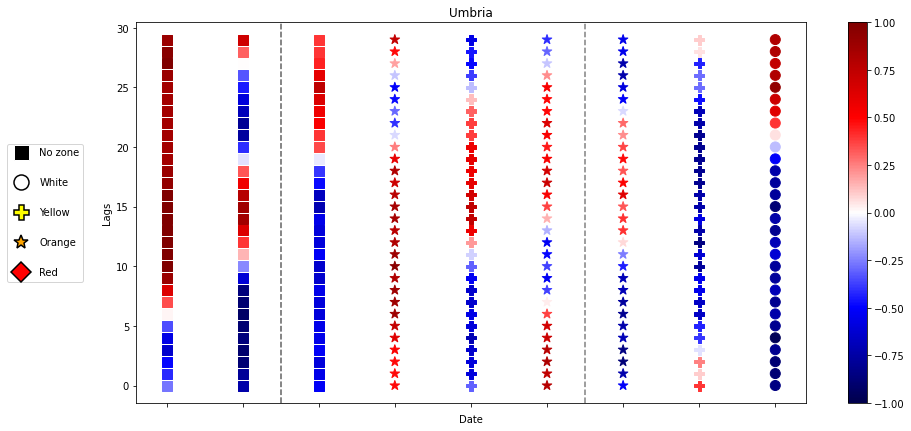

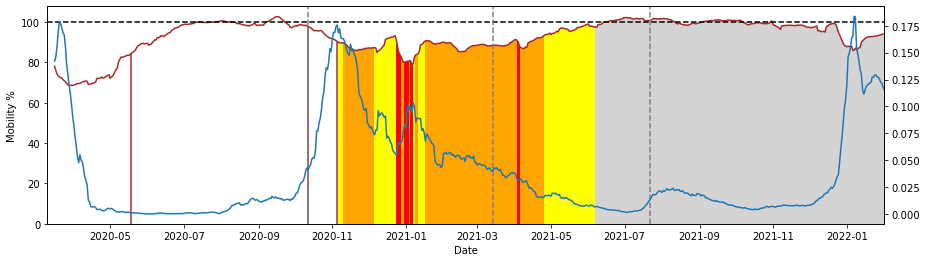

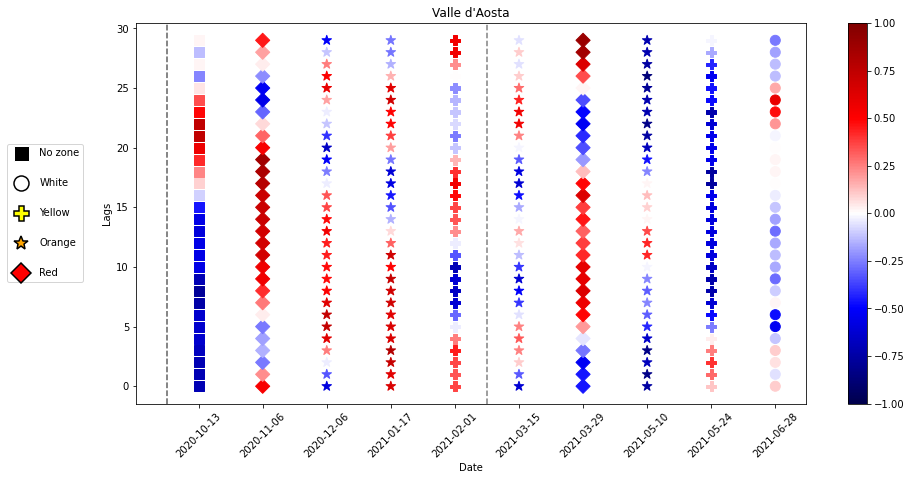

/home/lucarinna/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning:




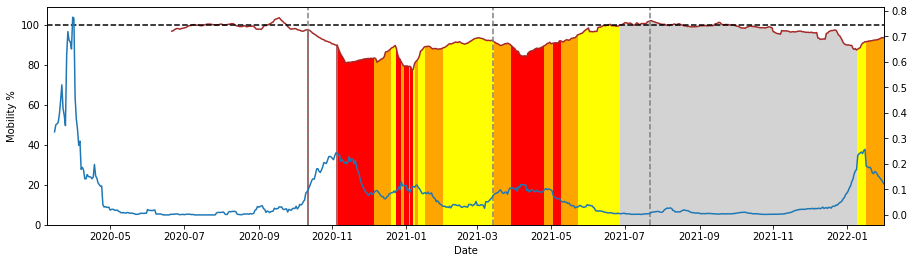

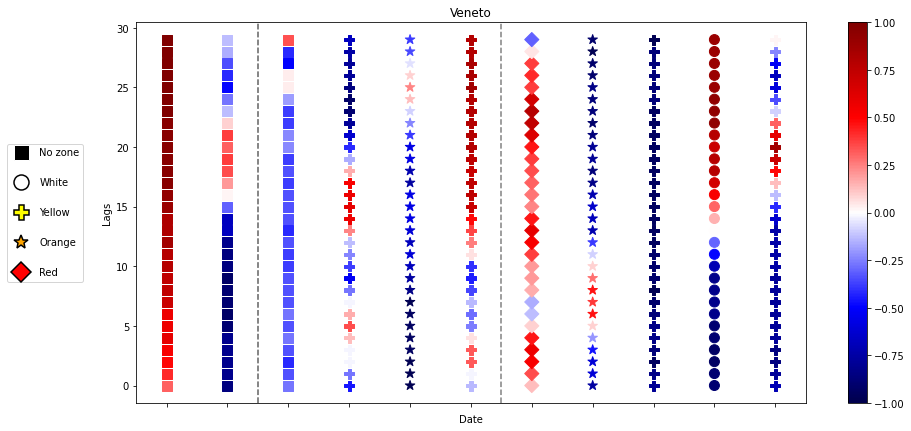

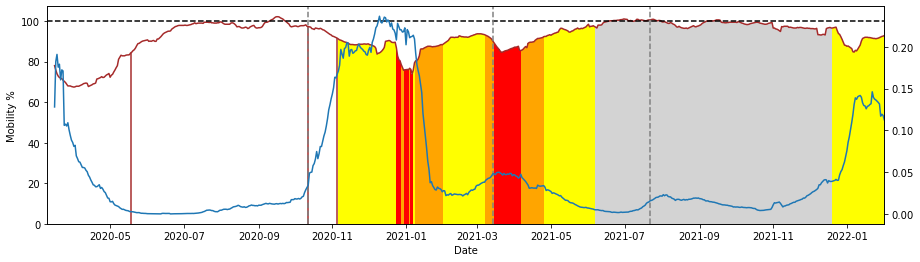

In [165]:
cmap = mpc.LinearSegmentedColormap.from_list("", ["darkblue","darkblue","blue","blue","blue",
                                                                "blue","blue","mediumslateblue","lightsteelblue","white",
                                                                "white","yellow","orange","red","red",
                                                                "red","red","red","darkred","darkred"])
marker_dict = {'no_zone'   : 's',
               'bianco'    : 'o',
               'giallo'    : 'P',
               'arancione' : '*',
               'rosso'     : 'D'}
legend_elements = [Line2D([0], [0], marker='s', color='w', label='No zone',
                          markerfacecolor='black', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='White',
                          markerfacecolor='w', markersize=15, markeredgewidth=1.5, 
                          markeredgecolor='black'),
                   Line2D([0], [0], marker='P', color='w', label='Yellow',
                          markerfacecolor='yellow', markersize=15, markeredgewidth=1.5, 
                          markeredgecolor='black'),
                   Line2D([0], [0], marker='*', color='w', label='Orange',
                          markerfacecolor='orange', markersize=15, markeredgewidth=1.5, 
                          markeredgecolor='black'),
                   Line2D([0], [0], marker='D', color='w', label='Red',
                          markerfacecolor='red', markersize=14, markeredgewidth=1.5, 
                          markeredgecolor='black')]
#  13 ottobre divieto di assembramento
waves_dict_ita = {'no_zone': [('2020-03-10', '2020-05-18'),
                              ('2020-05-19', '2020-10-12'),
                              ('2020-10-13', '2020-11-05')]}
fixed_tw = 10

for region in actual_regions:

    plt.figure(figsize=[15,7])
    actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))
    actual_dict = {**actual_dict, **waves_dict_ita}
    ticks_datetime_list = [datetime.datetime.strptime(start[0], "%Y-%m-%d").date() \
                           for start in [i for j in list(actual_dict.values()) for i in j] \
                           if ((datetime.datetime.strptime(start[1], "%Y-%m-%d").date() - datetime.datetime.strptime(start[0], "%Y-%m-%d").date()).days >=7)]
    ticks_datetime_list.sort()
    counter = 0

    for ix,color in enumerate(actual_dict.keys()):
        for pair in actual_dict[color]:
            start, stop = pair            
            
            if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
                if (isinstance(fixed_tw, int)):
                    stop = fixed_tw
                try :
                    stat = kendall_lag_correlation_GMD(applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}), dates_str_gmd,
                                                       applyfilter(df_norm, {"denominazione_regione" : [region]}), dates_str_pc,
                                                       start, stop, 30)
                    plt.scatter(x=[ticks_datetime_list.index(datetime.datetime.strptime(start, "%Y-%m-%d").date())]*30,
                             y=np.arange(30), c=stat['residential']['incidence'], 
                             vmin=-1, vmax=1, cmap='seismic', marker=marker_dict[color], s=100)
                except Exception:
                    #pass
                    counter+=1
    plt.colorbar()
    plt.title(region)
    plt.ylabel('Lags')
    plt.xlabel('Date')
    plt.xticks(range(len(ticks_datetime_list)-counter), ticks_datetime_list[:-counter], rotation=45)
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(-0.2,0.5), labelspacing=2)
    y_min, y_max = plt.ylim()
    plt.ylim(y_min, y_max)
    plt.vlines([[data > datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True) - 0.5,
                [data > datetime.datetime.strptime('2021-03-14', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True) - 0.5,
                [data > datetime.datetime.strptime('2020-07-22', "%Y-%m-%d").date() for data in ticks_datetime_list].index(True) - 0.5], 
                 y_min, y_max, ls='--', colors='gray')

    plt.show()
    
    fig, ax1 = plt.subplots(figsize=(15,4))
    start_date = "2020-03-10"
    start_col_date = "2020-11-06"
    end_date   = "2022-02-01"
    slice_mob, mask_mob = from_to(dates_str_gmd, start_date, end_date)
    slice_mob_c, mask_mob_c = from_to(dates_str_gmd, start_col_date, end_date)
    slice_col, mask_col = from_to(applyfilter(colors, {'denominazione_regione' : [region]}).data.values, start_col_date, end_date)
    slice_inc, mask_inc = from_to(dates_str_pc, start_date, end_date)
    translate = {'bianco'    : 'lightgray',
                 'giallo'    : 'yellow',
                 'arancione' : 'orange',
                 'rosso'     : 'red'}
    color_list = [translate[col] for col in applyfilter(colors, {'denominazione_regione' : [region]}).colore.values]
    ax2 = ax1.twinx()
    ax1.plot(dates_datetime_gmd[slice_mob], applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[mask_mob, 7].rolling(7).mean().values,
             label="GMD", color='brown')
    ax1.bar(dates_datetime_gmd[slice_mob_c], applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[:, 7].rolling(7).mean().iloc[mask_mob_c].values,
             label="GMD", color=color_list[slice_col], width=1)
    ax2.plot(dates_datetime_pc[slice_inc], applyfilter(df_norm, {"denominazione_regione" : [region]}).iloc[mask_inc,31].rolling(window=7).mean(), 
             label="Normalized incidence")
    ax1.plot([dates_datetime_gmd[slice_mob][0], dates_datetime_gmd[slice_mob][-1]], [100,100], '--', color='black')
    y_min, y_max = ax1.get_ylim()
    #ax1.vlines([datetime.datetime.strptime('2020-05-18', "%Y-%m-%d").date(),
    #            datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date(),
    #            datetime.datetime.strptime('2020-11-05', "%Y-%m-%d").date()], y_min, y_max, ls='--', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-05-18', "%Y-%m-%d").date()], 
                y_min, applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[mask_mob, 7].rolling(7).mean().values[list(dates_str_gmd[slice_mob]).index('2020-05-18')], ls='-', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date()], 
                y_min, applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[mask_mob, 7].rolling(7).mean().values[list(dates_str_gmd[slice_mob]).index('2020-10-12')], ls='-', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-11-05', "%Y-%m-%d").date()], 
                y_min, applyfilter(df_gmd, {"sub_region_1" : [region_dict_GMD[region]]}).iloc[mask_mob, 7].rolling(7).mean().values[list(dates_str_gmd[slice_mob]).index('2020-11-05')], ls='-', colors='brown')
    ax1.vlines([datetime.datetime.strptime('2020-10-12', "%Y-%m-%d").date(),
                datetime.datetime.strptime('2021-03-14', "%Y-%m-%d").date(),
                datetime.datetime.strptime('2021-07-22', "%Y-%m-%d").date()], y_min, y_max, ls='--', colors='gray')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mobility %')
    ax1.set_xlim(dates_datetime_gmd[slice_mob][0], dates_datetime_gmd[slice_mob][-1])
    ax1.set_ylim(y_min, y_max)
    #plt.legend()
    #ax2.set_ylabel('Y2 data', color='b')

    plt.show()
    #break

In [152]:
mask_mob

array([ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

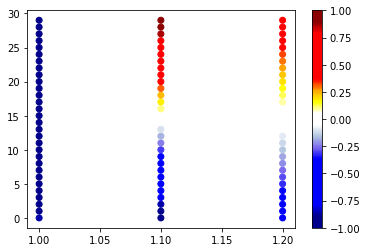

In [78]:




cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkblue","darkblue","blue","blue","blue",
                                                                "blue","blue","mediumslateblue","lightsteelblue","white",
                                                                "white","yellow","orange","red","red",
                                                                "red","red","red","darkred","darkred"])
#cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(-1.0,"red"), (0.0, "white"), (1.0, "blue")])

#plt.plot(range(5),range(5), c=range(5), cmap=cmap)
plt.scatter(np.ones(len(stat['driving']['incidence'])),
            np.arange(len(stat['driving']['incidence'])),
            c = stat['driving']['incidence'], cmap=cmap, vmin=-1, vmax=1)
plt.scatter(np.ones(30)+0.1,
            np.arange(30),
            c = np.linspace(-1,1,30), cmap=cmap, vmin=-1, vmax=1)
plt.scatter(np.ones(30)+0.2,
            np.arange(30),
            c = np.linspace(-0.5,0.5,30), cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()

## Testing stuff

In [201]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "Veneto"]

region_dict = dict(sorted({key : value for key,value in zip(region_sorted_pc, region_list_amd)}.items()))
region_dict

{'Abruzzo': 'Abruzzo Region',
 'Basilicata': 'Basilicata Region',
 'Calabria': 'Calabria Region',
 'Campania': 'Campania Region',
 'Emilia-Romagna': 'Emilia-Romagna Region',
 'Friuli Venezia Giulia': 'Autonomous Region Friuli-Venezia Giulia',
 'Lazio': 'Lazio Region',
 'Liguria': 'Liguria Region',
 'Lombardia': 'Lombardy Region',
 'Marche': 'Marche Region',
 'Molise': 'Molise Region',
 'Piemonte': 'Piedmont Region',
 'Puglia': 'Apulia Region',
 'Sardegna': 'Autonomous Region Sardinia',
 'Sicilia': 'Sicily Region',
 'Toscana': 'Tuscany Region',
 'Trentino alto adige': 'Autonomous Region Trentino-Alto Adige/Südtirol',
 'Umbria': 'Umbria Region',
 "Valle d'Aosta": 'Autonomous Region Aosta Valley',
 'Veneto': 'Veneto Region'}

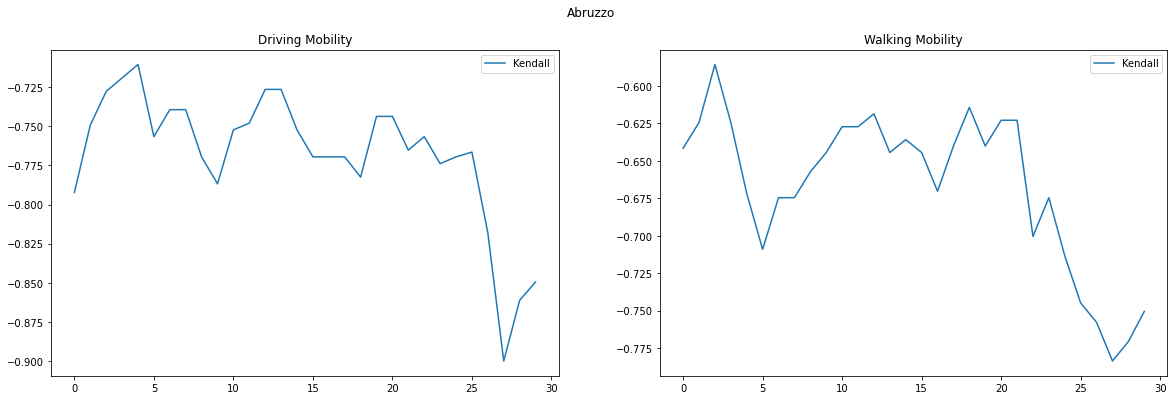

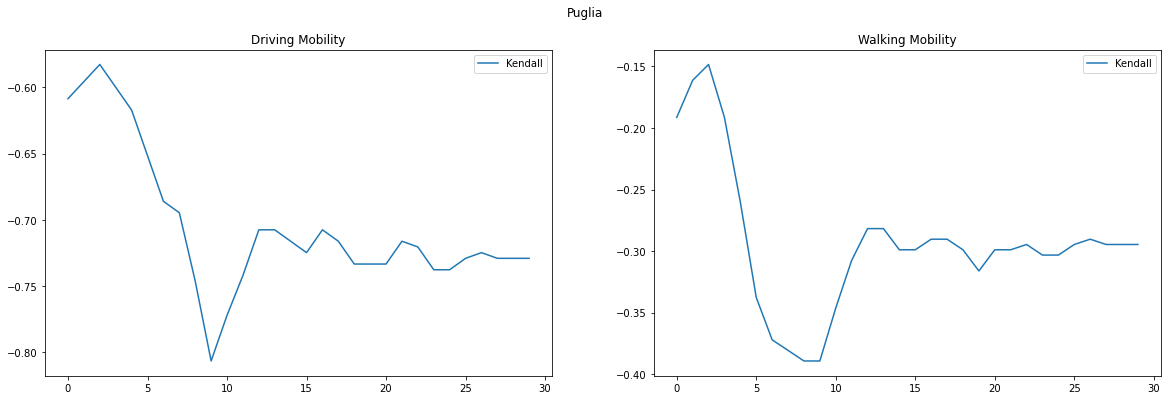

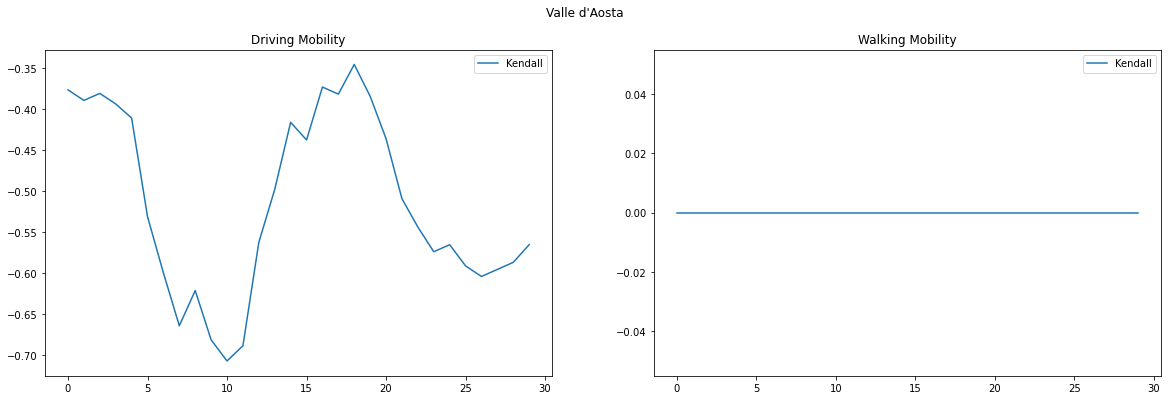

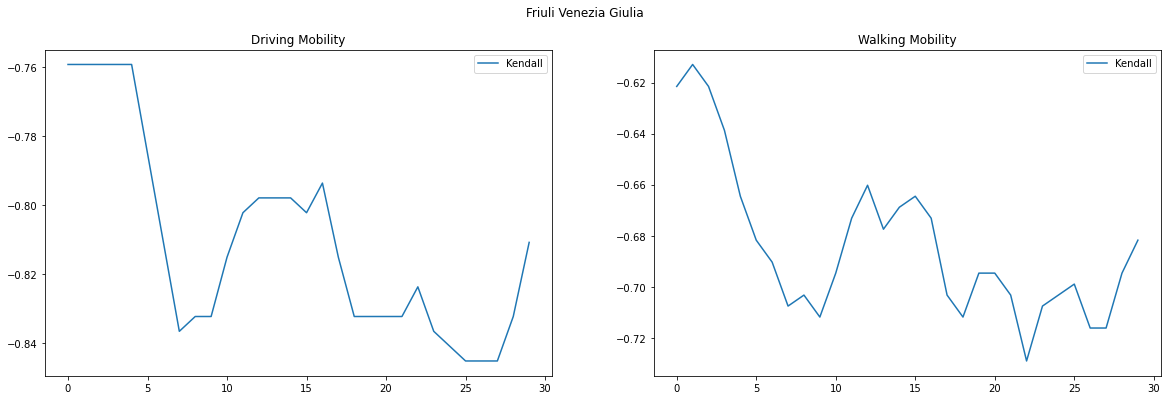

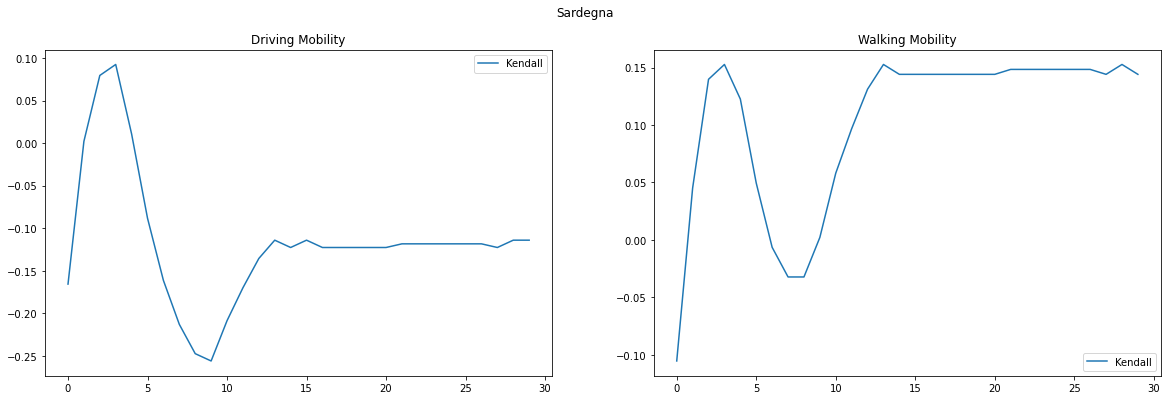

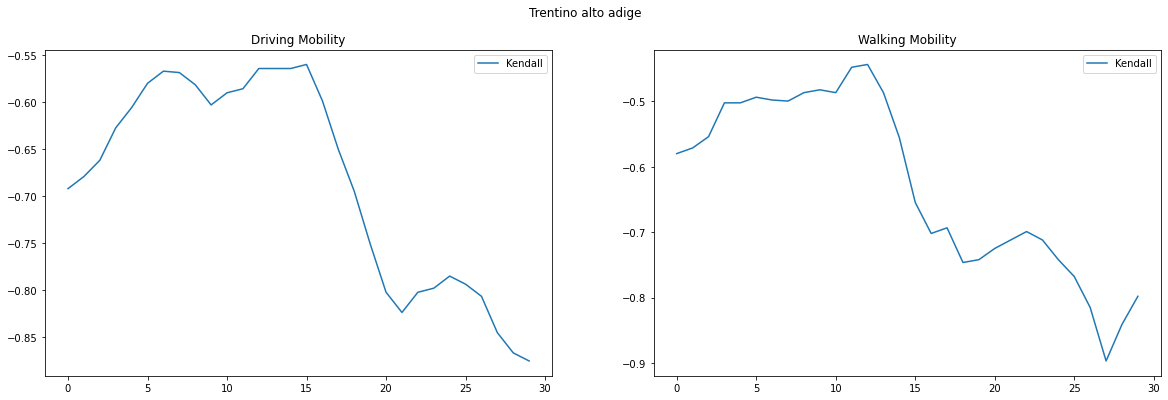

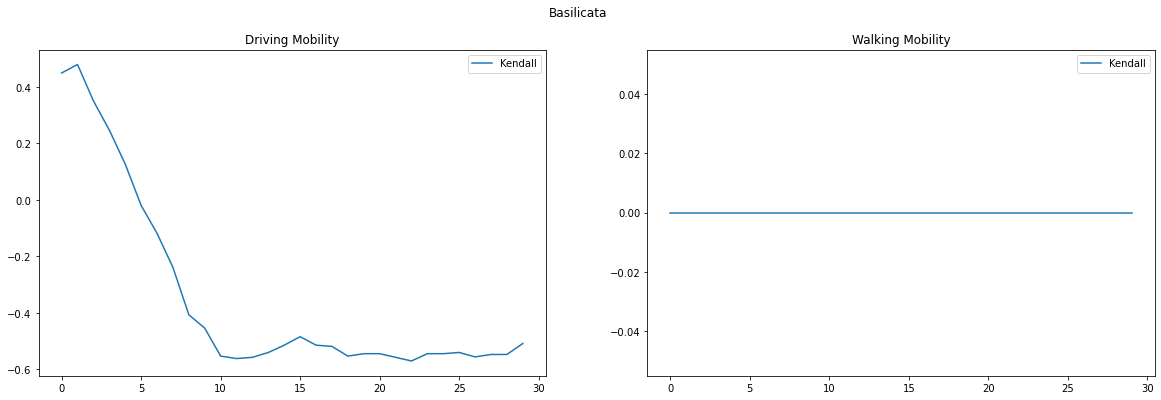

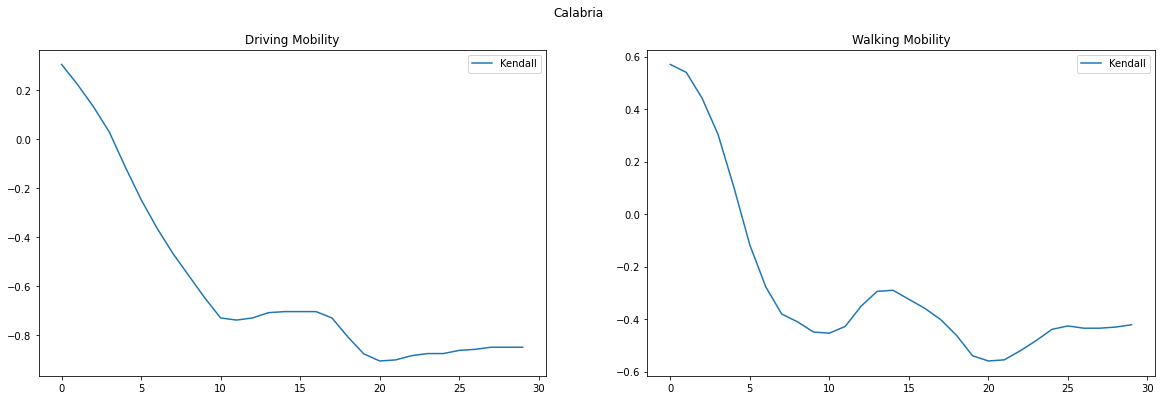

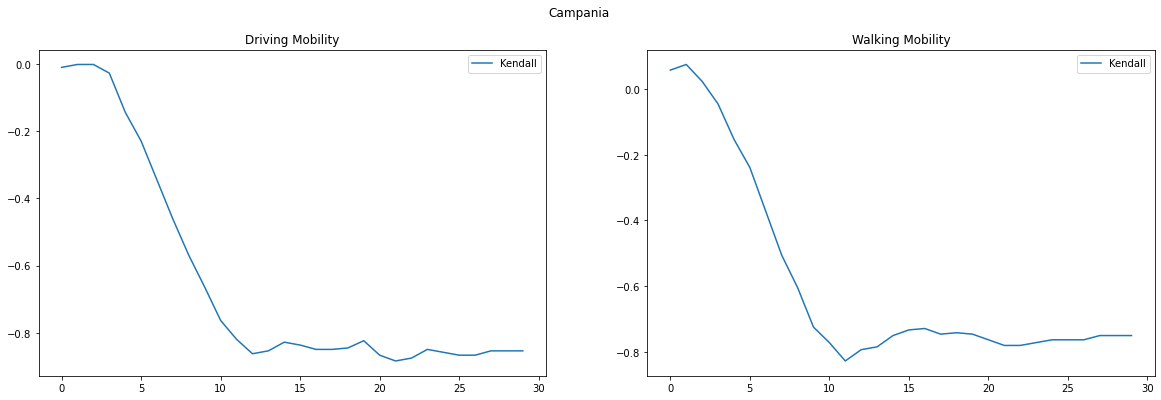

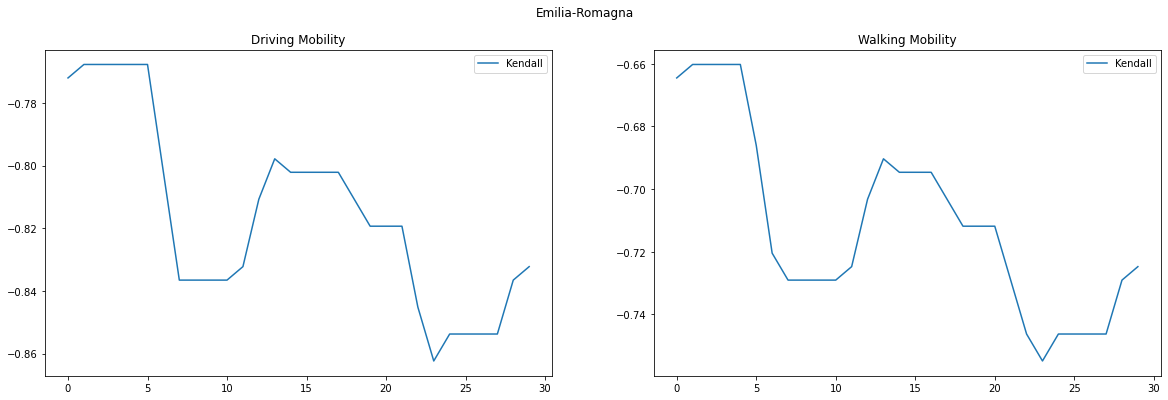

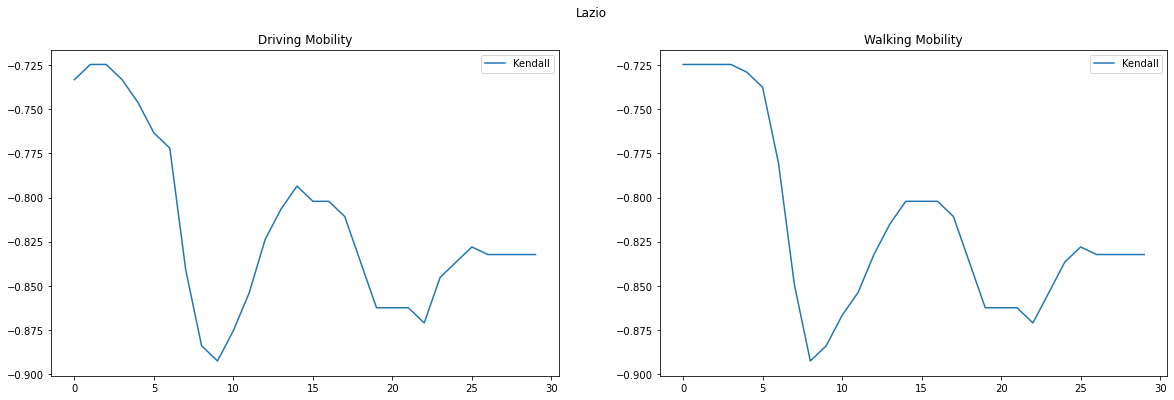

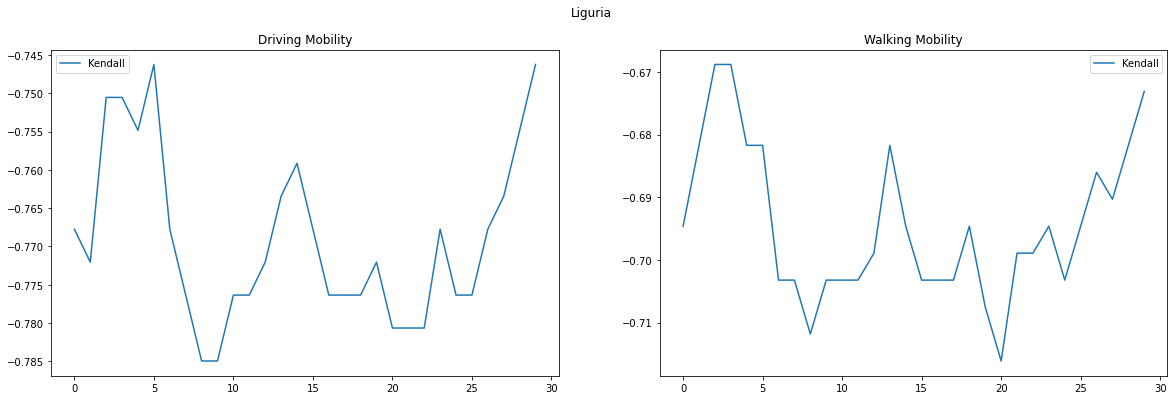

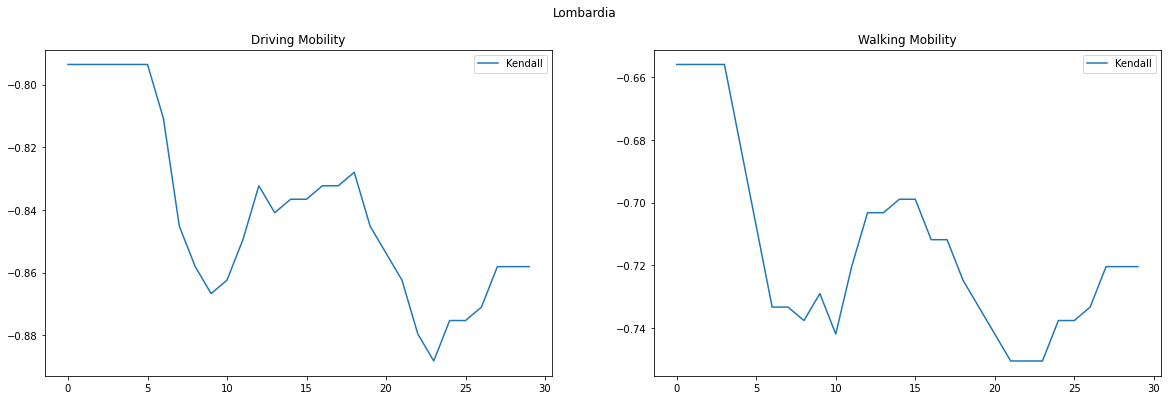

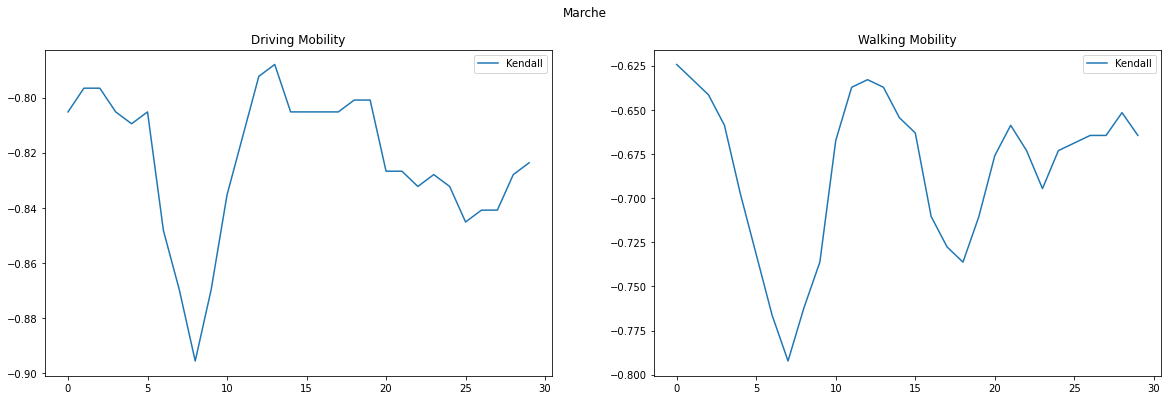

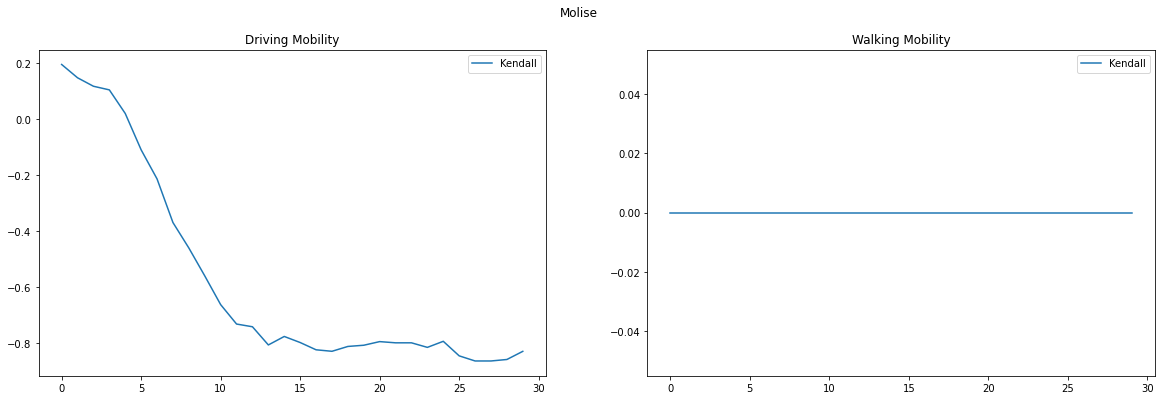

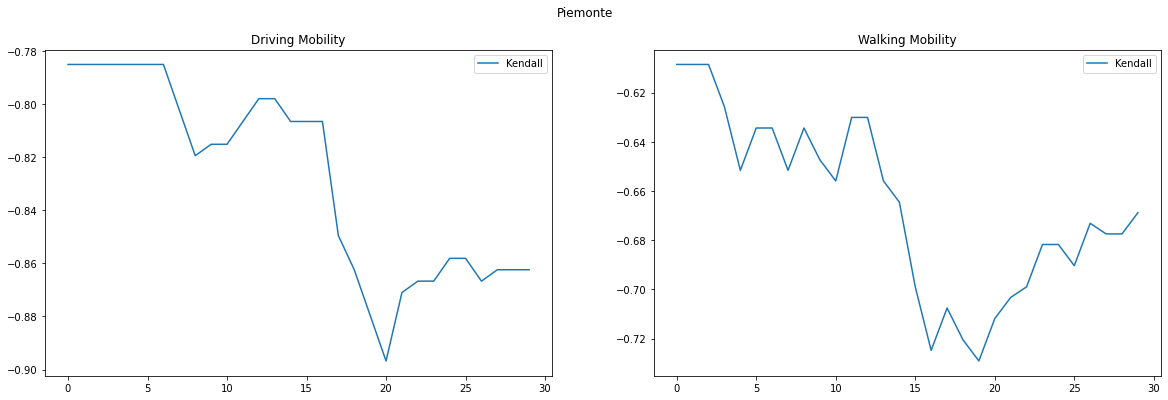

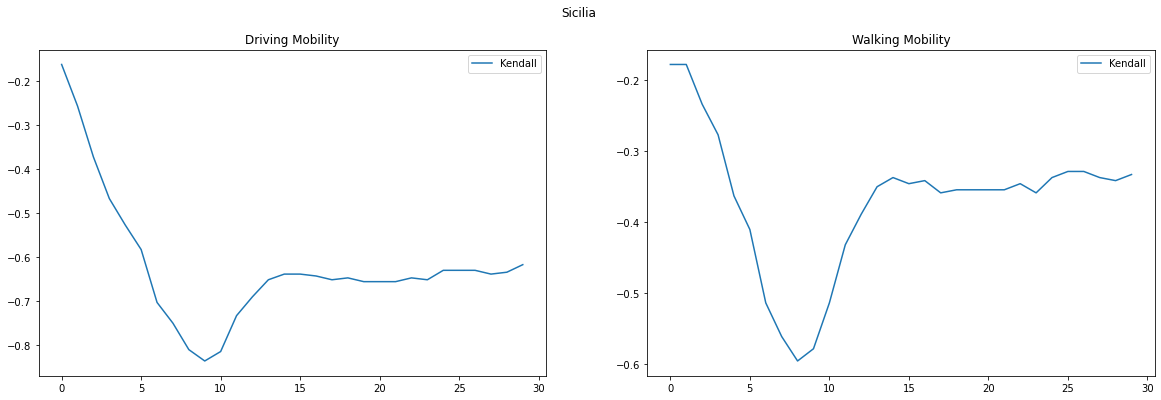

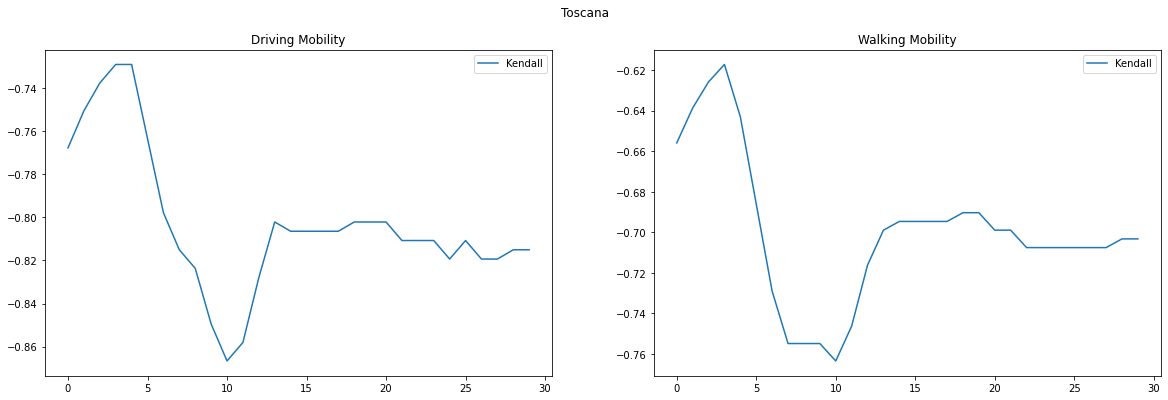

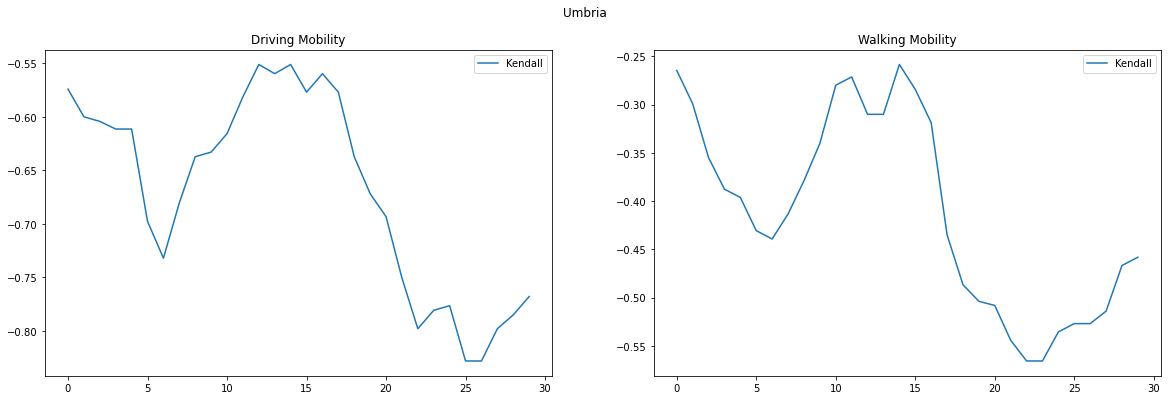

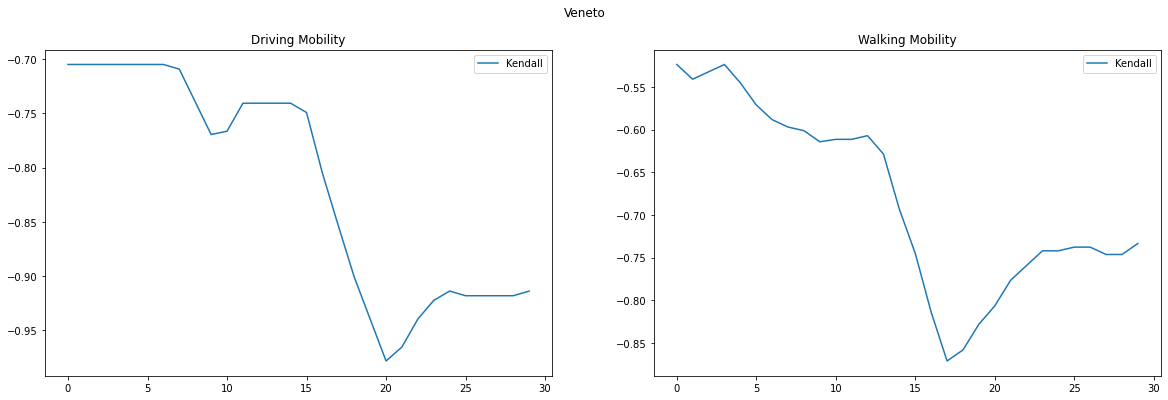

In [87]:
t_start = "2021-04-01"
t_final = "2021-05-01"
lags = np.arange(30)
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)


for kk, region_amd in enumerate(region_list_amd):

    # Printing
    fig, ax = plt.subplots(1,2, figsize=[20,6])
    for month in np.arange(1):
        
        driving_spearman = np.zeros((len(lags)))
        walking_spearman = np.zeros((len(lags)))
        driving_kendall  = np.zeros((len(lags)))
        walking_kendall  = np.zeros((len(lags)))
    
        x = applyfilter(df_amd, {"region" : [region_amd]}).iloc[:, 30*month+x_window_mask+2].values#-100
        for ii,lag in enumerate(lags):    
            #y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).iloc[lag+y_window_mask,2].values
            y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).iloc[:,2:].rolling(window=7).mean().iloc[30*month+lag+y_window_mask,0].values
            #driving_spearman[ii] = ss.spearmanr(x[0], y)[0]
            #driving_pearson[ii] = ss.kendalltau(np.diff(x[0]), np.diff(y))[0]
            #driving_kendall[ii]  = ss.kendalltau((x[0]-x[0].mean())/x[0].std(), (y-y.mean())/y.std())[0]
            driving_kendall[ii]  = ss.kendalltau(x[0], y, variant='c')[0]
            try:
                #walking_spearman[ii] = ss.spearmanr(x[1], y)[0]
                walking_kendall[ii]  = ss.kendalltau(x[1], y)[0]
            except Exception:
                pass


        ax[0].plot(lags, driving_kendall,  label="Kendall")
        #ax[0].plot(lags, driving_pearson,  label="Pearson")
        #ax[0].plot(lags, driving_spearman, label="Spearman")
        try:
            #ax[1].plot(lags, walking_spearman, label="Spearman")
            ax[1].plot(lags, walking_kendall,  label="Kendall")
        except Exception:
            pass
        
    ax[0].title.set_text("Driving Mobility")
    ax[1].title.set_text("Walking Mobility")
    ax[0].legend()
    ax[1].legend()
    plt.suptitle(region_sorted_pc[kk])
    plt.show()
    #plt.plot(x[0]/x[0].mean(), label='mobility')
    #plt.plot(y/y.mean(), label='incidence')
    #plt.legend()

In [166]:
region_sorted_pc = ["Abruzzo", "Puglia", "Valle d'Aosta", "Friuli Venezia Giulia",
                    "Sardegna", "Trentino alto adige", "Basilicata", "Calabria", 
                    "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", 
                    "Marche", "Molise", "Piemonte", "Sicilia", "Toscana", "Umbria", "V"]

array(['Abruzzo Region', 'Apulia Region',
       'Autonomous Region Aosta Valley',
       'Autonomous Region Friuli-Venezia Giulia',
       'Autonomous Region Sardinia',
       'Autonomous Region Trentino-Alto Adige/Südtirol',
       'Basilicata Region', 'Calabria Region', 'Campania Region',
       'Emilia-Romagna Region', 'Italy', 'Lazio Region', 'Liguria Region',
       'Lombardy Region', 'Marche Region', 'Molise Region',
       'Piedmont Region', 'Sicily Region', 'Tuscany Region',
       'Umbria Region', 'Veneto Region'], dtype=object)

In [44]:
prova = {"driving" : dict(), "walking" : dict()}
prova["driving"]["incidence"] = 33
prova

{'driving': {'incidence': 33}, 'walking': {}}

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


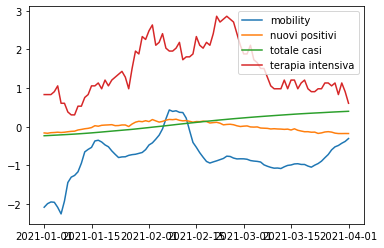

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


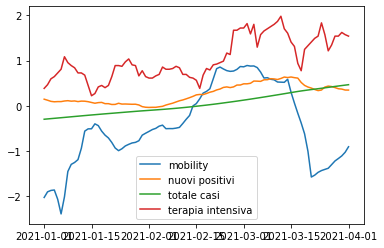

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


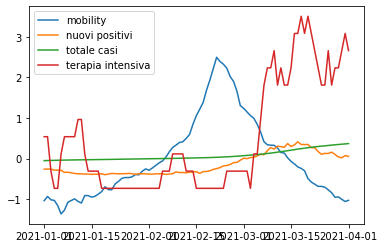

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


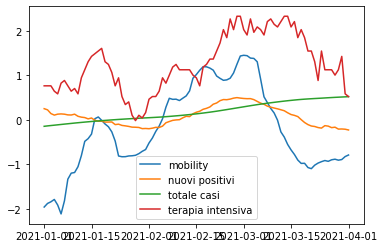

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


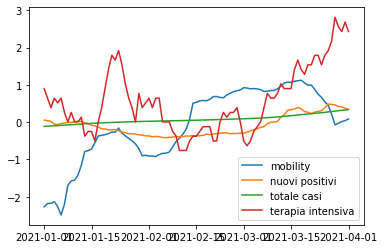

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


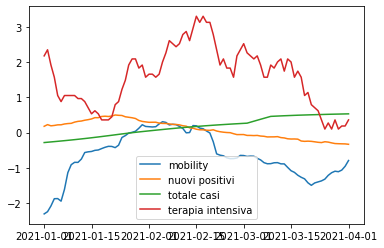

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


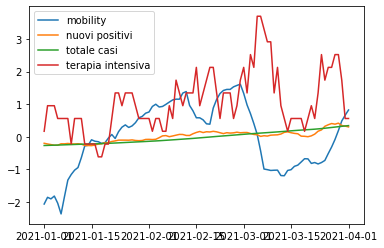

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


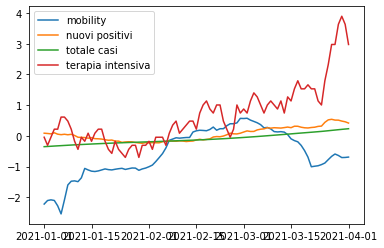

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


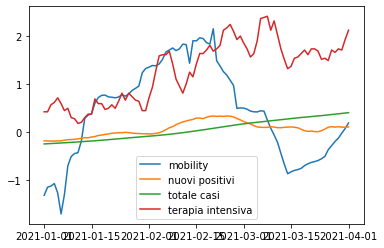

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


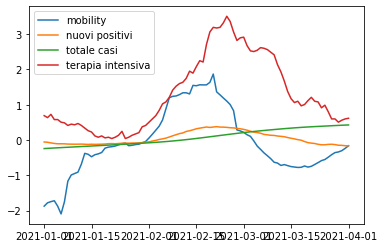

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


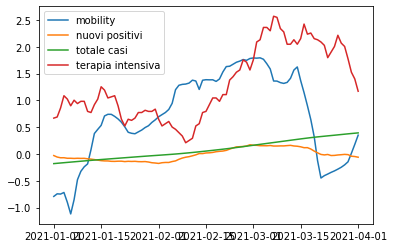

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


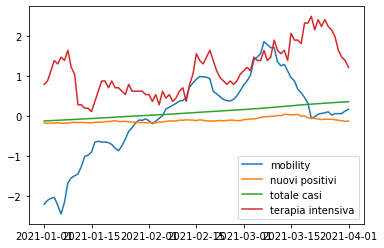

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


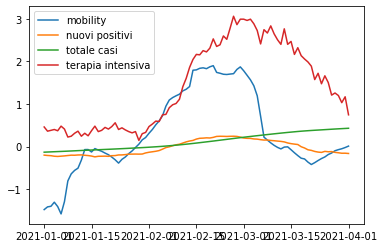

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


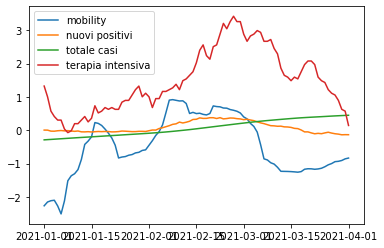

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


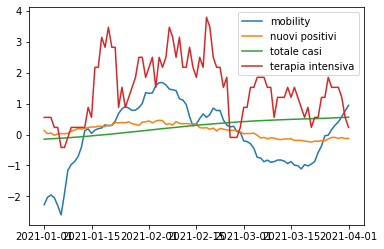

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


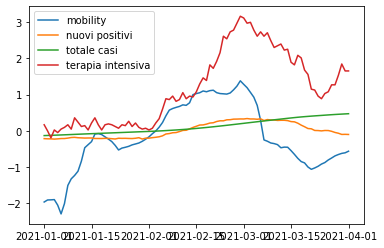

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


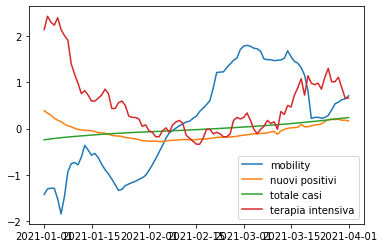

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


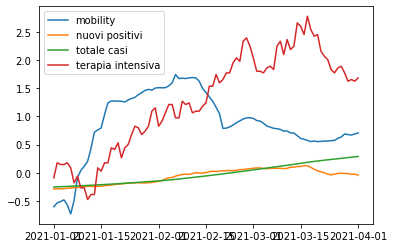

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


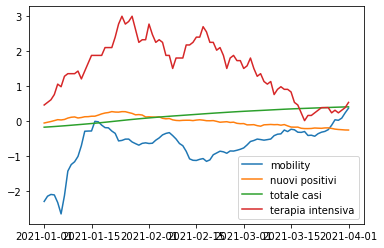

/tmp/ipykernel_14405/1189774799.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['data', 'denominazione_regione'], dtype='object')
  y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()


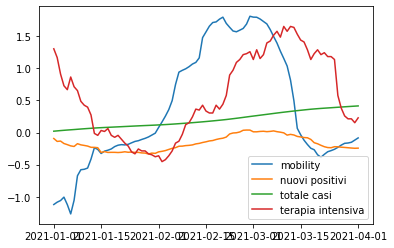

In [77]:
t_start = "2021-01-01"
t_final = "2021-04-01"
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)


for kk, region_amd in enumerate(region_list_amd):

        x = applyfilter(df_amd, {"region" : [region_amd]}).iloc[:, x_window_mask+2].values#-100
        y = applyfilter(df_pc, {"denominazione_regione" : [region_sorted_pc[kk]]}).rolling(window=7).mean()
        x = (x-x.mean())/x.std()
        y = (y-y.mean())/y.std()
        plt.plot(dates_datetime_amd[x_window_slice], x[0], label="mobility")
        plt.plot(dates_datetime_pc[y_window_slice], y.iloc[30*month+lag+y_window_mask,0].values, label="nuovi positivi")
        plt.plot(dates_datetime_pc[y_window_slice], y.iloc[30*month+lag+y_window_mask,1].values, label="totale casi")
        plt.plot(dates_datetime_pc[y_window_slice], y.iloc[30*month+lag+y_window_mask,3].values, label="terapia intensiva")
        plt.legend()
        plt.show()

In [168]:
from scipy.signal import correlate, correlation_lags
t_start = "2020-11-03"
t_final = "2020-12-04"
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)
a_ext = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+14,0].values 
a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask,0].values
b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
a = (a - a.min()) / (a.max() - a.min())
b = (b - b.min()) / (b.max() - b.min())

In [346]:
t_start = "2021-01-04"
t_final = "2021-02-04"
x_window_slice, x_window_mask = from_to(dates_str_amd, t_start, t_final)
y_window_slice, y_window_mask = from_to(dates_str_pc,  t_start, t_final)

lag_corr = np.zeros(50)
for lag in np.arange(50):
    
    #a_ext = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+14,0].values 
    a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+lag,0].values
    b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
    a = (a - a.min()) / (a.max() - a.min())
    b = (b - b.min()) / (b.max() - b.min())
    lag_corr[lag] = sum((a -b)**2)

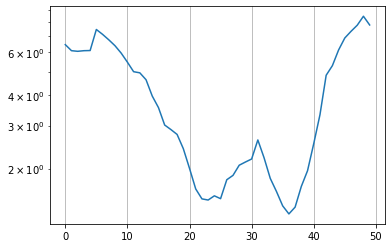

In [347]:
plt.plot(lag_corr)
plt.yscale('log')
plt.grid()

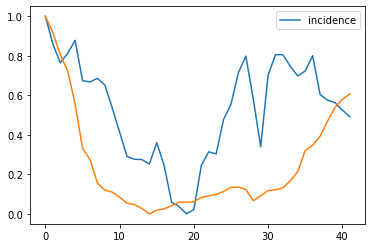

In [327]:
a = applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[y_window_mask+30,0].values
b = applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values
a = (a - a.min()) / (a.max() - a.min())
b = (b - b.min()) / (b.max() - b.min())
plt.plot(a, label="incidence")
plt.plot(b)
plt.legend()

In [209]:
x_window_mask

array([293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323])

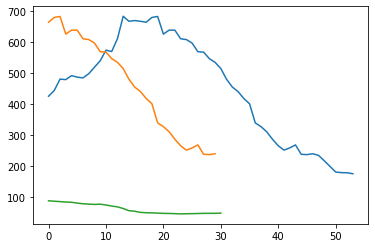

In [220]:
plt.plot(applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[np.arange(251,281+lag),0].values)
plt.plot(applyfilter(df_pc, {"denominazione_regione" : ["Abruzzo"]}).iloc[:,2:].rolling(window=7).mean().iloc[np.arange(251,281)+17,0].values)
plt.plot(applyfilter(df_amd, {"region" : ["Abruzzo Region"]}).iloc[0, x_window_mask+2].values)

# Whole ITALY
***

In [107]:
df_ita_inc = pd.read_csv('DATA/prot_civ/itaregioni.csv')
df_ita_inc = df_ita_inc.groupby('data', as_index=False).sum()
df_ita_inc['data'] = [date.split('T')[0] for date in df_ita_inc['data']]
df_ita_inc

data  codice_regione         lat        long  \
0    2020-02-24             249  903.972147  256.745065   
1    2020-02-25             249  903.972147  256.745065   
2    2020-02-26             249  903.972147  256.745065   
3    2020-02-27             249  903.972147  256.745065   
4    2020-02-28             249  903.972147  256.745065   
..          ...             ...         ...         ...   
716  2022-02-09             249  903.972147  256.745065   
717  2022-02-10             249  903.972147  256.745065   
718  2022-02-11             249  903.972147  256.745065   
719  2022-02-12             249  903.972147  256.745065   
720  2022-02-13             249  903.972147  256.745065   

     ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
0                       101                 26                   127   
1                       114                 35                   149   
2                       128                 36                   164   
3                       248                 56                   304   
4                       345                 64                   409   
..                      ...                ...                   ...   
716                   17932               1350                 19282   
717                   17354               1322                 18676   
718                   16824               1265                 18089   
719                   16310               1223                 17533   
720                   16060               1190                 17250   

     isolamento_domiciliare  totale_positivi  variazione_totale_positivi  ...  \
0                        94              221                           0  ...   
1                       162              311                          90  ...   
2                       221              385                          74  ...   
3                       284              588                         203  ...   
4                       412              821                         233  ...   
..                      ...              ...                         ...  ...   
716                 1855343          1874625                      -53175  ...   
717                 1794598          1813274                      -61351  ...   
718                 1733036          1751125                      -62149  ...   
719                 1678081          1695614                      -55511  ...   
720                 1621423          1638673                      -56941  ...   

     casi_da_sospetto_diagnostico  casi_da_screening  totale_casi    tamponi  \
0                             0.0                0.0          229       4324   
1                             0.0                0.0          322       8623   
2                             0.0                0.0          400       9587   
3                             0.0                0.0          650      12014   
4                             0.0                0.0          888      15695   
..                            ...                ...          ...        ...   
716                           0.0                0.0     11847436  178300531   
717                           0.0                0.0     11923631  178984246   
718                           0.0                0.0     11991109  179648032   
719                           0.0                0.0     12053330  180235677   
720                           0.0                0.0     12105675  180698558   

     casi_testati  ingressi_terapia_intensiva  \
0             0.0                         0.0   
1             0.0                         0.0   
2             0.0                         0.0   
3             0.0                         0.0   
4             0.0                         0.0   
..            ...                         ...   
716    49816014.0                        90.0   
717    49937792.0                        83.0   
718    50046103.0                       100.0   
719    501488

In [108]:
df_ita_gmd = pd.DataFrame()
for year in ['2020', '2021', '2022']:
    df = pd.read_csv("DATA/GMD/"+year+"_IT_Region_Mobility_Report.csv")
    mask_1 = df['sub_region_1'].isnull()
    df.drop(labels = ["sub_region_1", "country_region_code", "country_region", "sub_region_2", 'metro_area','iso_3166_2_code',
             'census_fips_code', 'place_id'], axis=1, inplace=True)
    df_ita_gmd = pd.concat([df_ita_gmd, df[mask_1]], ignore_index=True)
df_ita_gmd

date  retail_and_recreation_percent_change_from_baseline  \
0    2020-02-15                                                3.0    
1    2020-02-16                                                3.0    
2    2020-02-17                                                0.0    
3    2020-02-18                                                3.0    
4    2020-02-19                                                0.0    
..          ...                                                ...    
733  2022-02-17                                              -10.0    
734  2022-02-18                                              -12.0    
735  2022-02-19                                              -12.0    
736  2022-02-20                                              -14.0    
737  2022-02-21                                              -14.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
0                                                 -1.0   
1                                                  2.0   
2                                                  1.0   
3                                                  1.0   
4                                                 -1.0   
..                                                 ...   
733                                               16.0   
734                                               15.0   
735                                                8.0   
736                                                0.0   
737                                               11.0   

     parks_percent_change_from_baseline  \
0                                  35.0   
1                                  26.0   
2                                   7.0   
3                                  16.0   
4                                  11.0   
..                                  ...   
733                                14.0   
734                                11.0   
735                                17.0   
736                                34.0   
737                                 4.0   

     transit_stations_percent_change_from_baseline  \
0                                              9.0   
1                                             11.0   
2                                              3.0   
3                                              4.0   
4                                              3.0   
..                                             ...   
733                                          -22.0   
734                                          -21.0   
735                                          -18.0   
736                                           -9.0   
737                                          -23.0   

     workplaces_percent_change_from_baseline  \
0                                        0.0   
1                                        1.0   
2                                        1.0   
3                                        1.0   
4                                        1.0   
..                                       ...   
733                                    -11.0   
734                                    -10.0   
735                                     -8.0   
736                                     -4.0   
737                                    -11.0   

     residential_percent_change_from_baseline  
0                                        -1.0  
1                                        -2.0  
2                                         0.0  
3                                         0.0  
4                                         0.0  
..                                        ...  
733                                       5.0  
734                                       5.0  
735                                       3.0  
736                                       2.0  
737                                       5.0  

[738 rows x 7 columns]

In [109]:
df_ita_rt = pd.read_csv("DATA/iss_rt_italia.csv")
df_ita_rt

data  rt_positivi  rt_positivi_err68perc  rt_sintomatici  \
0    2020-01-28          NaN                    NaN             NaN   
1    2020-01-29          NaN                    NaN             NaN   
2    2020-01-30          NaN                    NaN             NaN   
3    2020-01-31          NaN                    NaN             NaN   
4    2020-02-01          NaN                    NaN             NaN   
..          ...          ...                    ...             ...   
751  2022-02-17     0.649599               0.070647        0.643938   
752  2022-02-18     0.635457               0.072261        0.631001   
753  2022-02-19     0.619601               0.074001        0.616546   
754  2022-02-20     0.601986               0.075830        0.600413   
755  2022-02-21     0.572596               0.078644        0.572584   

     rt_sintomatici_err68perc  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  
..                        ...  
751                  0.071258  
752                  0.072702  
753                  0.074257  
754                  0.075917  
755                  0.078558  

[756 rows x 5 columns]

In [127]:
waves_dict_ita = {'wave_twindow': [('2020-03-10', '2021-05-18'),
                                   ('2020-05-19', '2021-11-03'),
                                   ('2020-11-03', '2021-12-25'),
                                   ('2021-01-01', '2021-01-31'),
                                   ('2021-02-01', '2021-05-31'),
                                   ('2021-06-01', '2021-10-31'),
                                   ('2021-11-01', '2022-01-13')]}

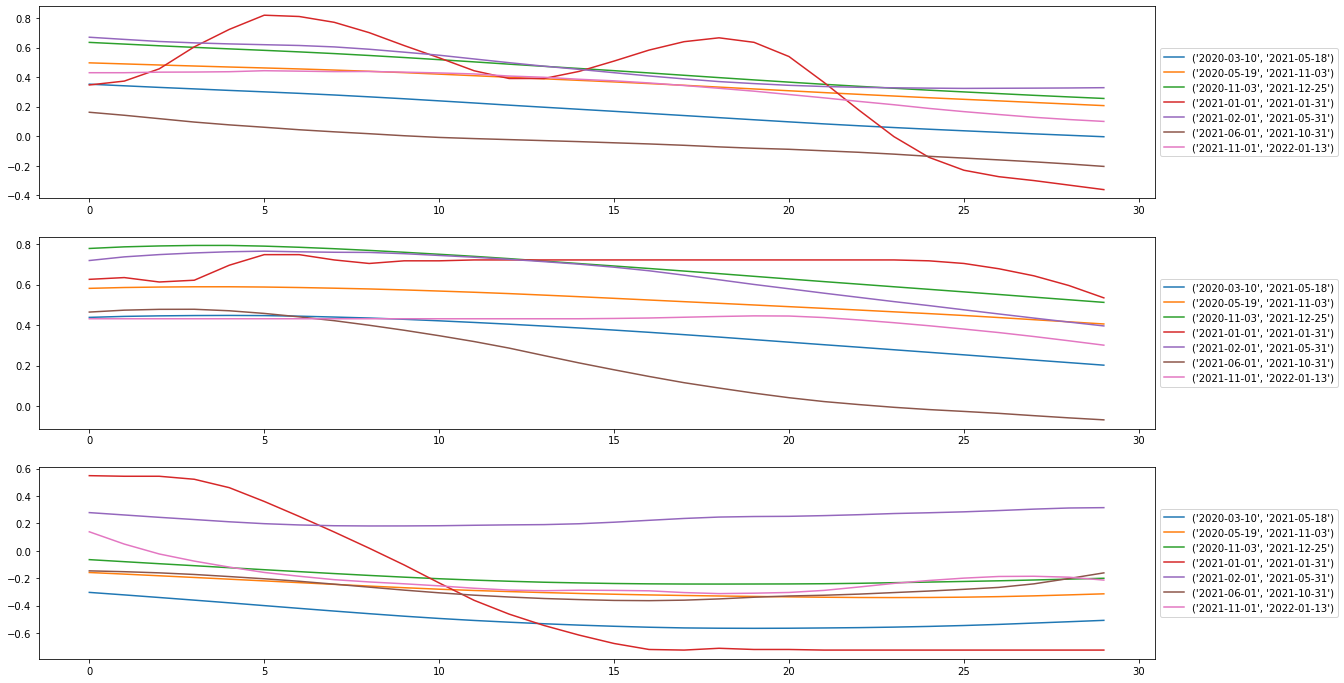

In [156]:
fixed_tw = None #4
n_lags = 30

fig, ax = plt.subplots(3,1, figsize=[20,12])
#actual_dict = generate_tseries(applyfilter(colors, {'denominazione_regione' : [region]}))
actual_dict = waves_dict_ita

for pair in actual_dict['wave_twindow']:
    start, stop = pair            

    if ((datetime.datetime.strptime(stop, "%Y-%m-%d").date() - datetime.datetime.strptime(start, "%Y-%m-%d").date()).days >= 7):
        if (isinstance(fixed_tw, int)):
            stop = fixed_tw

        lags = np.arange(n_lags)
        correlation = {"residential" : {"incidence"  : np.zeros(n_lags), 
                                        "prevalence" : np.zeros(n_lags), 
                                        "rt"         : np.zeros(n_lags)}}

        x_window_slice, x_window_mask = from_to(df_ita_gmd['date'], start, stop)
        y_window_slice, y_window_mask = from_to(df_ita_inc['data'], start, stop)
        rt_window_slice, rt_window_mask = from_to(df_ita_rt['data'], start, stop)

        x  = df_ita_gmd.iloc[:, 6].rolling(window=7).mean()
        y  = df_ita_inc.iloc[:,8:].rolling(window=7).mean()
        rt = df_ita_rt.iloc[:,3].values #positivi sintomatici

        for lag in lags:    
            correlation['residential']['incidence'][lag]   = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask,2].values)[0]
            correlation['residential']['prevalence'][lag]  = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask,0].values)[0]
            #correlation['residential']['terapia_in'][lag]  = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask,3].values)[0]
            #correlation['residential']['ricoverati'][lag]  = ss.kendalltau(x[x_window_mask].values, y.iloc[lag+y_window_mask,2].values)[0]
            correlation['residential']['rt'][lag]          = ss.kendalltau(x[x_window_mask].values, rt[lag+rt_window_mask])[0]

            
        ax[0].plot(correlation['residential']['incidence'], label = pair)
        ax[1].plot(correlation['residential']['prevalence'], label = pair)
        ax[2].plot(correlation['residential']['rt'], label = pair)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [158]:
y

totale_positivi  variazione_totale_positivi  nuovi_positivi  \
0                NaN                         NaN             NaN   
1                NaN                         NaN             NaN   
2                NaN                         NaN             NaN   
3                NaN                         NaN             NaN   
4                NaN                         NaN             NaN   
..               ...                         ...             ...   
716     2.077356e+06               -76143.000000    86971.428571   
717     2.003791e+06               -73565.142857    81710.000000   
718     1.937045e+06               -66745.571429    77085.714286   
719     1.875198e+06               -61847.000000    72667.714286   
720     1.813116e+06               -62082.142857    68811.571429   

     dimessi_guariti       deceduti  casi_da_sospetto_diagnostico  \
0                NaN            NaN                           NaN   
1                NaN            NaN                           NaN   
2                NaN            NaN                           NaN   
3                NaN            NaN                           NaN   
4                NaN            NaN                           NaN   
..               ...            ...                           ...   
716     9.379452e+06  148817.000000                           0.0   
717     9.534794e+06  149172.285714                           0.0   
718     9.678557e+06  149513.428571                           0.0   
719     9.813012e+06  149839.428571                           0.0   
720     9.943908e+06  150160.000000                           0.0   

     casi_da_screening   totale_casi       tamponi  casi_testati  \
0                  NaN           NaN           NaN           NaN   
1                  NaN           NaN           NaN           NaN   
2                  NaN           NaN           NaN           NaN   
3                  NaN           NaN           NaN           NaN   
4                  NaN           NaN           NaN           NaN   
..                 ...           ...           ...           ...   
716                0.0  1.160562e+07  1.760726e+08  4.944696e+07   
717                0.0  1.168776e+07  1.768192e+08  4.957181e+07   
718                0.0  1.176512e+07  1.775341e+08  4.969154e+07   
719                0.0  1.183805e+07  1.782121e+08  4.980586e+07   
720                0.0  1.190718e+07  1.788581e+08  4.991575e+07   

     ingressi_terapia_intensiva  totale_positivi_test_molecolare  \
0                           NaN                              NaN   
1                           NaN                              NaN   
2                           NaN                              NaN   
3                           NaN                              NaN   
4                           NaN                              NaN   
..                          ...                              ...   
716                   96.714286                     7.625443e+06   
717                   95.000000                     7.650654e+06   
718                   93.000000                     7.674228e+06   
719                   87.857143                     7.695975e+06   
720                   82.285714                     7.716530e+06   

     totale_positivi_test_antigenico_rapido  tamponi_test_molecolare  \
0                                       NaN                      NaN   
1                                       NaN                      NaN   
2                                       NaN                      NaN   
3                                       NaN                      NaN   
4                                       NaN                      NaN   
..                                      ...                      ...   
716                            3.980182e+06             8.248565e+07   
717                            4.037103e+06             8.265192e+07   
718                            4.090888e+06             8.281542e+07   
719  

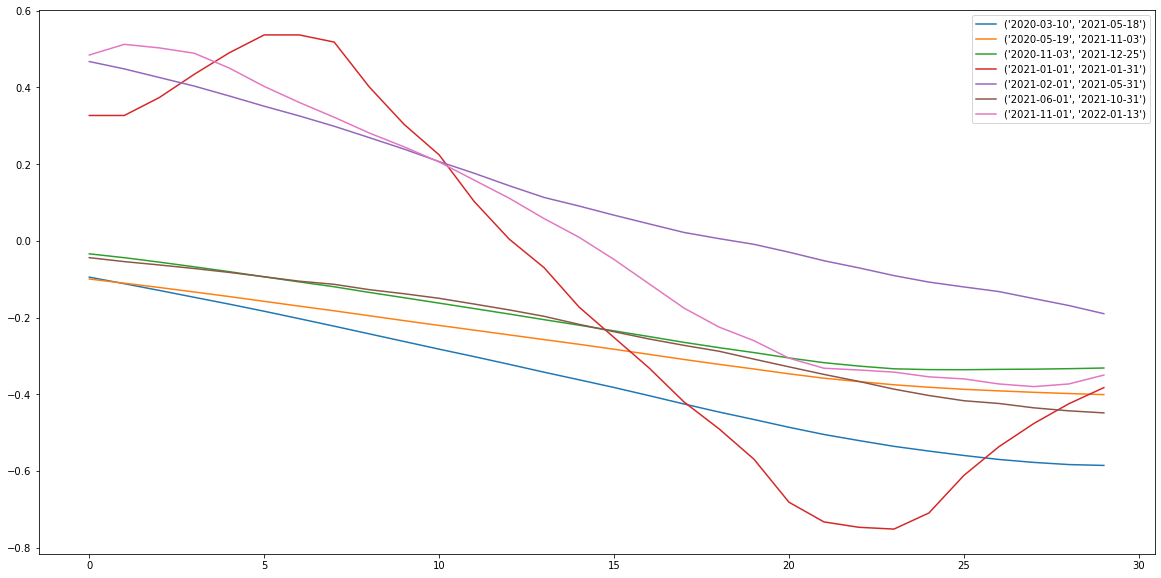

In [172]:
from datetime import timedelta

plt.figure(figsize=[20,10])

lag = range(30)

for pair in actual_dict['wave_twindow']:
    start, stop = pair     
    correlation = {"residential" : {"incidence"  : np.zeros(30), 
                                    "prevalence" : np.zeros(30), 
                                    "rt"         : np.zeros(30)}}

    for q,j in enumerate(lag):
        mob_in = datetime.datetime.strptime(start, '%Y-%m-%d')
        m = mob_in + timedelta(days=j)
        inc_startdate = m.strftime("%Y-%m-%d")

        mob_end = datetime.datetime.strptime(stop, '%Y-%m-%d')
        inc = mob_end + timedelta(days=j)
        inc_enddate = inc.strftime("%Y-%m-%d")

        df_italyInc1 = df_ita_inc.copy()
        df_italyInc1.iloc[:,4:] = df_italyInc1.iloc[:,4:].rolling(7).mean()
       # dataframe1 = dataframe.copy()
        data_df1 = df_ita_gmd.copy()
        data_df1.iloc[:,1:] = data_df1.iloc[:,1:].rolling(7).mean()
       # dataframe1 = dataframe1[dataframe['data'].between(inc_startdate, inc_enddate)] 
        df_italyInc1 = df_italyInc1[df_italyInc1['data'].between(inc_startdate, inc_enddate)] 

        data_df1  = data_df1[data_df1['date'].between(start, stop)]
        
        y5 = data_df1['residential_percent_change_from_baseline']
        tau5, p_value5 = ss.kendalltau((df_italyInc1['ricoverati_con_sintomi'][1:].values-df_italyInc1['ricoverati_con_sintomi'][:-1].values)/(df_italyInc1['tamponi'][1:].values - df_italyInc1['tamponi'][:-1].values), y5[1:])
        correlation['residential']['incidence'][q] = tau5
    
    plt.plot(correlation['residential']['incidence'], label=pair)

plt.legend()
plt.show()
        

In [160]:
df_italyInc1

data  codice_regione         lat        long  \
645  2021-11-30             249  903.972147  256.745065   
646  2021-12-01             249  903.972147  256.745065   
647  2021-12-02             249  903.972147  256.745065   
648  2021-12-03             249  903.972147  256.745065   
649  2021-12-04             249  903.972147  256.745065   
..          ...             ...         ...         ...   
714  2022-02-07             249  903.972147  256.745065   
715  2022-02-08             249  903.972147  256.745065   
716  2022-02-09             249  903.972147  256.745065   
717  2022-02-10             249  903.972147  256.745065   
718  2022-02-11             249  903.972147  256.745065   

     ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
645             4888.285714         625.857143           5514.142857   
646             4976.714286         642.000000           5618.714286   
647             5063.714286         657.714286           5721.428571   
648             5154.714286         672.285714           5827.000000   
649             5240.714286         687.714286           5928.428571   
..                      ...                ...                   ...   
714            19076.428571        1462.142857          20538.571429   
715            18857.000000        1437.428571          20294.428571   
716            18625.857143        1412.571429          20038.428571   
717            18344.428571        1393.285714          19737.714286   
718            18033.571429        1368.285714          19401.857143   

     isolamento_domiciliare  totale_positivi  variazione_totale_positivi  ...  \
645            1.727480e+05     1.782621e+05                 5680.000000  ...   
646            1.784243e+05     1.840430e+05                 5780.857143  ...   
647            1.843606e+05     1.900820e+05                 6039.000000  ...   
648            1.904744e+05     1.963014e+05                 6219.428571  ...   
649            1.967690e+05     2.026974e+05                 6396.000000  ...   
..                      ...              ...                         ...  ...   
714            2.211348e+06     2.231887e+06               -85986.428571  ...   
715            2.133204e+06     2.153499e+06               -78387.714286  ...   
716            2.057317e+06     2.077356e+06               -76143.000000  ...   
717            1.984053e+06     2.003791e+06               -73565.142857  ...   
718            1.917643e+06     1.937045e+06               -66745.571429  ...   

     casi_da_sospetto_diagnostico  casi_da_screening   totale_casi  \
645                           0.0                0.0  4.993142e+06   
646                           0.0                0.0  5.005861e+06   
647                           0.0                0.0  5.019017e+06   
648                           0.0                0.0  5.032649e+06   
649                           0.0                0.0  5.046817e+06   
..                            ...                ...           ...   
714                           0.0                0.0  1.142548e+07   
715                           0.0                0.0  1.151824e+07   
716                           0.0                0.0  1.160562e+07   
717                           0.0                0.0  1.168776e+07   
718                           0.0                0.0  1.176512e+07   

          tamponi  casi_testati  ingressi_terapia_intensiva  \
645  1.177167e+08  3.775122e+07                   56.142857   
646  1.182719e+08  3.782428e+07                   58.000000   
647  1.188313e+08  3.789846e+07                   57.714286   
648  1.193952e+08  3.797373e+07                   58.000000   
649  1.199647e+08  3.805139e+07                   56.714286   
..            ...           ...                         ...   
714  1.744801e+08  4.918352e+07                   99.857143   
715  1.752930e+08  4.931833e+07                   98.714286   
716  1.760726e+08  4.944696e+07                   96.714

In [168]:
df_italyInc1['ricoverati_con_sintomi'][1:].values -df_italyInc1['ricoverati_con_sintomi'][:-1].values

array([  88.42857143,   87.        ,   91.        ,   86.        ,
         90.42857143,  106.28571429,  121.57142857,  121.57142857,
        147.85714286,  156.85714286,  158.71428571,  157.14285714,
        153.14285714,  155.        ,  172.85714286,  143.57142857,
        148.14285714,  148.14285714,  147.        ,  164.28571429,
        174.        ,  176.42857143,  197.71428571,  184.57142857,
        188.        ,  213.42857143,  231.71428571,  244.        ,
        290.57142857,  306.28571429,  334.        ,  339.        ,
        362.28571429,  372.85714286,  403.28571429,  398.        ,
        423.        ,  491.57142857,  523.57142857,  555.85714286,
        572.42857143,  593.57142857,  563.57142857,  545.85714286,
        489.71428571,  491.42857143,  438.85714286,  412.57142857,
        340.14285714,  313.        ,  287.28571429,  209.42857143,
        153.14285714,  129.71428571,   90.57142857,   84.14285714,
         71.57142857,   27.71428571,   44.42857143,   27.71428